# Algoritmos Evolutivos & Aprendizado por Reforço

## Alunos

- João Vitor Vendemiato Fatoretto - 199944
- Natan Beltrão da Cunha Pevidor Carvalho - 184972

## Parte 1 - Algoritmos Evolutivos

Neste projeto, treinamos dois algoritmos diferentes para aprender a jogar o jogo Pacman ([código](https://gitlab.techniek.hva.nl/artificial-intelligence/pacman-contest-3)). Nesta primeira parte, treinamos um algoritmo evolutivo.

Como os fantasmas do jogo se comportam de forma aleatória, não é possível encontrar um caminho fixo para a vitória. Por isso, tentamos desenvolver um algoritmo que chegasse a uma estratégia ideal e não um caminho fixo. Para isso, nos inspiramos em Brandstetter & Ahmadi, 2012. Uma estratégia (implementada em [strategy.py](./strategy.py)) consiste em 5 árvores, onde as folhas consistem em valores calculados a partir do estado do jogo e os outros nós são operadores binários. Cada árvore está associada a uma das 4 direções e a ação a ser tomada é a que tiver maior valor dentre as ações possíveis no estado atual.

### Valores

Os valores (implementados em [values.py](./values.py)) possíveis para as folhas de uma árvore são:

- Coordenadas do Pacman
- Quantidade, Distância e Coordenadas do Fantasma não-comestível mais próximo
- Quantidade, Distância e Coordenadas do Fantasma comestível mais próximo
- Quantidade, Distância e Coordenadas da comida mais próxima
- Quantidade, Distância e Coordenadas da cápsula mais próxima
- Valores constantes: -1, 0, 0.1, 1, 10

### Operadores

Os operadores (implementados em [operators.py](./operators.py)) possíveis para os outros nós são:

- Subtração
- Adição
- Multiplicação
- Divisão (retorna 0 caso o divisor seja 0)
- Máximo
- Mínimo

### Geração Inicial

Para criar a primeira geração, implementamos em [strategyGenerator.py](./strategyGenerator.py) um mecanismo de geração de estratégia, onde a chance de um nó ser uma folha aumenta conforme sua profundidade, de forma a gerar árvores com tamanhos variados mas que tendam a não serem muito grandes. Cada geração possui 100 estratégias.

In [1]:
import strategyGenerator

def createGeneration(size=50):
    generation = []
    for _ in range(size):
        generation.append(strategyGenerator.generateStrategy())
    return generation

generation = createGeneration()

Para cada estratégia em uma geração, executamos 3 jogos de forma a levar em conta a aleatoriedade do movimento dos fantasmas. A medida de fitness de cada estratégia é a média dos scores obtidos nesses 3 jogos.

Ao final de cada execução, utilizamos o método da roleta para selecionar os membros que irão para a próxima geração, dos quais:

- 15% serão estratégias sobreviventes, simplesmente replicadas da geração anterior
- 15% serão estratégias com alguma mutação
- 70% serão estratégias resultantes da reprodução de duas estratégias da geração anterior, com crossover

Inicialmente, para o método da roleta, utilizamos a raiz quadrada da função fitness (com windowing para evitar raízes negativas). Porém, devido ao tempo gasto rodando cada geração, passamos a utilizar a função de fitness (ainda com windowing) diretamente para permitir uma convergência mais rápida.

### Mutação

As mutações possíveis, implementadas em [generationReproduction.py](./generationReproduction.py), são:

- A geração de uma nova árvore para substituir uma das 5 árvores da estratégia
- A troca de posição entre duas árvores já existentes
- A troca de ramos entre duas árvores já existentes

### Crossover

O crossover, também implementado em [generationReproduction.py](./generationReproduction.py), seleciona as árvores novas a partir de 3 estratégias:

- Selecionar uma das árvores dentre as duas estratégias selecionadas para reprodução
- Selecionar uma das árvores dentre as duas estratégias selecionadas para reprodução e trocar um dos seus ramos pelo ramo da outa árvore
- Fundir as duas árvores anteriores em uma nova raiz comum selecionada aleatoriamente

Executamos, então, 5 gerações para cada layout do jogo, iniciando com smallClassic. O melhor método dentre essas gerações é retornado para ser utilizado no futuro.

In [2]:
import generationReproduction
import globalValues
import numpy as np
import pacman
import time
import copy

def selectByRoulette(gen, scores):
    probability = np.sqrt(np.array(scores) - min(scores))
    probability = probability / np.sum(probability)
    return np.random.choice(gen, p=probability)

def runGeneticLearning(layout, generation, iterations=50):
    startTime = time.time()
    generationAverage = []
    generationMax = []
    generationMin = []
    winningStrategies = []
    
    args = pacman.readCommand(["-l", layout, "-p", "GeneticAgent", "-n", "3", "-q"])

    for i in range(iterations):
        print("\n\n\n======== STARTING GENERATION %s ========\n\n\n" % i)
        averageScore = []
        fitness = []

        for strategy in generation:
            globalValues.strategy = strategy
            games = pacman.runGames(**args)
            scores = [g.state.getScore() for g in games]
            individualFitness = [g.state.getScore() - 10 * g.state.getNumFood() - 40 * len(g.state.getCapsules()) for g in games]
            averageScore.append(sum(scores)/len(scores))
            fitness.append(sum(individualFitness))

        generationAverage.append(sum(averageScore)/len(averageScore))
        generationMax.append(max(averageScore))
        generationMin.append(min(averageScore))
        winningStrategies.append(copy.deepcopy(generation[fitness.index(max(fitness))]))

        if i < iterations - 1:
            newGeneration = []
            for _ in range(round(len(generation) / 10)):
                newGeneration.append(selectByRoulette(generation, fitness))
            for _ in range(round(len(generation) / 10)):
                newGeneration.append(generationReproduction.mutate(selectByRoulette(generation, fitness)))
            for _ in range(round(len(generation) - len(newGeneration))):
                firstStrategy = selectByRoulette(generation, fitness)
                secondStrategy = selectByRoulette(generation, fitness)
                newGeneration.append(generationReproduction.crossover(firstStrategy, secondStrategy))
            generation = newGeneration
    
    winningStrategiesAverageScores = []
    for strategy in winningStrategies:
        globalValues.strategy = strategy
        args = pacman.readCommand(["-l", layout, "-p", "GeneticAgent", "-n", "10", "-q"])
        games = pacman.runGames(**args)
        scores = [g.state.getScore() for g in games]
        winningStrategiesAverageScores.append(sum(scores)/len(scores))
    winningStrategy = winningStrategies[winningStrategiesAverageScores.index(max(winningStrategiesAverageScores))]
    print("Winning Strategy:", winningStrategy)
    print("Winning Strategy's Generation:", winningStrategiesAverageScores.index(max(winningStrategiesAverageScores)))
    print("Winning Strategy's Average Score:", max(winningStrategiesAverageScores))
    print("Execution time: %s minutes" % ((time.time() - startTime) / 60))
    return (generationAverage, generationMax, generationMin, winningStrategy)

generationAverage, generationMax, generationMin, smallClassicStrategy = runGeneticLearning("smallClassic", generation)

layout:  smallClassic



======== STARTING GENERATION 0 ========



Pacman died! Score: -428
Pacman died! Score: -435
Pacman died! Score: -539
Average Score: -467.3333333333333
Scores:        -428.0, -435.0, -539.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -499
Pacman died! Score: -432
Pacman died! Score: -421
Average Score: -450.6666666666667
Scores:        -499.0, -432.0, -421.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -442
Pacman died! Score: -440
Pacman died! Score: -424
Average Score: -435.3333333333333
Scores:        -442.0, -440.0, -424.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -512
Pacman died! Score: -447
Pacman died! Score: -483
Average Score: -480.6666666666667
Scores:        -512.0, -447.0, -483.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -450
Pacman died! Score: -452
Pacman died! Score: -502
Average Score: -468.0
Scores:        

Pacman died! Score: -440
Pacman died! Score: -439
Pacman died! Score: -556
Average Score: -478.3333333333333
Scores:        -440.0, -439.0, -556.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -484
Pacman died! Score: -458
Pacman died! Score: -431
Average Score: -457.6666666666667
Scores:        -484.0, -458.0, -431.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -433
Pacman died! Score: -423
Pacman died! Score: -442
Average Score: -432.6666666666667
Scores:        -433.0, -423.0, -442.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -428
Pacman died! Score: -471
Pacman died! Score: -462
Average Score: -453.6666666666667
Scores:        -428.0, -471.0, -462.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -469
Pacman died! Score: -440
Pacman died! Score: -424
Average Score: -444.3333333333333
Scores:        -469.0, -440.0, -424.0
Win Rate:      0/3 (0.00)
Record:

Pacman died! Score: -386
Pacman died! Score: -422
Pacman died! Score: -337
Average Score: -381.6666666666667
Scores:        -386.0, -422.0, -337.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -473
Pacman died! Score: -507
Pacman died! Score: -450
Average Score: -476.6666666666667
Scores:        -473.0, -507.0, -450.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -432
Pacman died! Score: -434
Pacman died! Score: -437
Average Score: -434.3333333333333
Scores:        -432.0, -434.0, -437.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -416
Pacman died! Score: -456
Pacman died! Score: -434
Average Score: -435.3333333333333
Scores:        -416.0, -456.0, -434.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -447
Pacman died! Score: -472
Pacman died! Score: -486
Average Score: -468.3333333333333
Scores:        -447.0, -472.0, -486.0
Win Rate:      0/3 (0.00)
Record:

Pacman died! Score: -475
Pacman died! Score: -491
Pacman died! Score: -464
Average Score: -476.6666666666667
Scores:        -475.0, -491.0, -464.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -424
Pacman died! Score: -418
Pacman died! Score: -448
Average Score: -430.0
Scores:        -424.0, -418.0, -448.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -434
Pacman died! Score: -429
Pacman died! Score: -450
Average Score: -437.6666666666667
Scores:        -434.0, -429.0, -450.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -503
Pacman died! Score: -490
Pacman died! Score: -502
Average Score: -498.3333333333333
Scores:        -503.0, -490.0, -502.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -519
Pacman died! Score: -637
Pacman died! Score: -440
Average Score: -532.0
Scores:        -519.0, -637.0, -440.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss

Pacman died! Score: -438
Pacman died! Score: -430
Pacman died! Score: -452
Average Score: -440.0
Scores:        -438.0, -430.0, -452.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -393
Pacman died! Score: -405
Pacman died! Score: -451
Average Score: -416.3333333333333
Scores:        -393.0, -405.0, -451.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -403
Pacman died! Score: -396
Pacman died! Score: -463
Average Score: -420.6666666666667
Scores:        -403.0, -396.0, -463.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -639
Pacman died! Score: -432
Pacman died! Score: -477
Average Score: -516.0
Scores:        -639.0, -432.0, -477.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -450
Pacman died! Score: -440
Pacman died! Score: -422
Average Score: -437.3333333333333
Scores:        -450.0, -440.0, -422.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss

Pacman died! Score: -422
Pacman died! Score: -422
Pacman died! Score: -418
Average Score: -420.6666666666667
Scores:        -422.0, -422.0, -418.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -382
Pacman died! Score: -422
Pacman died! Score: -424
Average Score: -409.3333333333333
Scores:        -382.0, -422.0, -424.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -424
Pacman died! Score: -464
Pacman died! Score: -440
Average Score: -442.6666666666667
Scores:        -424.0, -464.0, -440.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -392
Pacman died! Score: -429
Pacman died! Score: -392
Average Score: -404.3333333333333
Scores:        -392.0, -429.0, -392.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -465
Pacman died! Score: -423
Pacman died! Score: -502
Average Score: -463.3333333333333
Scores:        -465.0, -423.0, -502.0
Win Rate:      0/3 (0.00)
Record:

Pacman died! Score: -421
Pacman died! Score: -425
Average Score: -420.6666666666667
Scores:        -416.0, -421.0, -425.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -540
Pacman died! Score: -442
Pacman died! Score: -417
Average Score: -466.3333333333333
Scores:        -540.0, -442.0, -417.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -519
Pacman died! Score: -400
Pacman died! Score: -390
Average Score: -436.3333333333333
Scores:        -519.0, -400.0, -390.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -423
Pacman died! Score: -409
Pacman died! Score: -429
Average Score: -420.3333333333333
Scores:        -423.0, -409.0, -429.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss



======== STARTING GENERATION 5 ========



Pacman died! Score: -436
Pacman died! Score: -390
Pacman died! Score: -393
Average Score: -406.3333333333333
Scores:        -436.0, -390.0, -393.0
Win Rate:   

Pacman died! Score: -398
Pacman died! Score: -405
Pacman died! Score: -390
Average Score: -397.6666666666667
Scores:        -398.0, -405.0, -390.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -515
Pacman died! Score: -456
Pacman died! Score: -484
Average Score: -485.0
Scores:        -515.0, -456.0, -484.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -451
Pacman died! Score: -430
Pacman died! Score: -541
Average Score: -474.0
Scores:        -451.0, -430.0, -541.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -450
Pacman died! Score: -411
Pacman died! Score: -394
Average Score: -418.3333333333333
Scores:        -450.0, -411.0, -394.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -502
Pacman died! Score: -420
Pacman died! Score: -457
Average Score: -459.6666666666667
Scores:        -502.0, -420.0, -457.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss

Pacman died! Score: -249
Pacman died! Score: -443
Pacman died! Score: -97
Average Score: -263.0
Scores:        -249.0, -443.0, -97.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -427
Pacman died! Score: -461
Pacman died! Score: -424
Average Score: -437.3333333333333
Scores:        -427.0, -461.0, -424.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -462
Pacman died! Score: -450
Pacman died! Score: -408
Average Score: -440.0
Scores:        -462.0, -450.0, -408.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -547
Pacman died! Score: -436
Pacman died! Score: -456
Average Score: -479.6666666666667
Scores:        -547.0, -436.0, -456.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -471
Pacman died! Score: -423
Pacman died! Score: -422
Average Score: -438.6666666666667
Scores:        -471.0, -423.0, -422.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
P

Pacman died! Score: -538
Pacman died! Score: -380
Pacman died! Score: -405
Average Score: -441.0
Scores:        -538.0, -380.0, -405.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -477
Pacman died! Score: -386
Pacman died! Score: -413
Average Score: -425.3333333333333
Scores:        -477.0, -386.0, -413.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -462
Pacman died! Score: -482
Pacman died! Score: -435
Average Score: -459.6666666666667
Scores:        -462.0, -482.0, -435.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -429
Pacman died! Score: -443
Pacman died! Score: -425
Average Score: -432.3333333333333
Scores:        -429.0, -443.0, -425.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -389
Pacman died! Score: -436
Pacman died! Score: -425
Average Score: -416.6666666666667
Scores:        -389.0, -436.0, -425.0
Win Rate:      0/3 (0.00)
Record:        Loss

Pacman died! Score: -383
Pacman died! Score: -403
Pacman died! Score: -421
Average Score: -402.3333333333333
Scores:        -383.0, -403.0, -421.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -409
Pacman died! Score: -505
Pacman died! Score: -423
Average Score: -445.6666666666667
Scores:        -409.0, -505.0, -423.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -409
Pacman died! Score: -511
Pacman died! Score: -394
Average Score: -438.0
Scores:        -409.0, -511.0, -394.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -397
Pacman died! Score: -405
Pacman died! Score: -388
Average Score: -396.6666666666667
Scores:        -397.0, -405.0, -388.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -476
Pacman died! Score: -426
Pacman died! Score: -412
Average Score: -438.0
Scores:        -476.0, -426.0, -412.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss

Pacman died! Score: -451
Pacman died! Score: -400
Pacman died! Score: -393
Average Score: -414.6666666666667
Scores:        -451.0, -400.0, -393.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -375
Pacman died! Score: -386
Pacman died! Score: -446
Average Score: -402.3333333333333
Scores:        -375.0, -386.0, -446.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -415
Pacman died! Score: -424
Pacman died! Score: -436
Average Score: -425.0
Scores:        -415.0, -424.0, -436.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -420
Pacman died! Score: -403
Pacman died! Score: -424
Average Score: -415.6666666666667
Scores:        -420.0, -403.0, -424.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -420
Pacman died! Score: -382
Pacman died! Score: -378
Average Score: -393.3333333333333
Scores:        -420.0, -382.0, -378.0
Win Rate:      0/3 (0.00)
Record:        Loss

Pacman died! Score: -412
Pacman died! Score: -394
Pacman died! Score: -379
Average Score: -395.0
Scores:        -412.0, -394.0, -379.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -424
Pacman died! Score: -427
Pacman died! Score: -490
Average Score: -447.0
Scores:        -424.0, -427.0, -490.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -432
Pacman died! Score: -437
Pacman died! Score: -424
Average Score: -431.0
Scores:        -432.0, -437.0, -424.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -440
Pacman died! Score: -437
Pacman died! Score: -244
Average Score: -373.6666666666667
Scores:        -440.0, -437.0, -244.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -504
Pacman died! Score: -454
Pacman died! Score: -383
Average Score: -447.0
Scores:        -504.0, -454.0, -383.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -43

Pacman died! Score: -413
Pacman died! Score: -531
Pacman died! Score: -509
Average Score: -484.3333333333333
Scores:        -413.0, -531.0, -509.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -441
Pacman died! Score: -406
Pacman died! Score: -379
Average Score: -408.6666666666667
Scores:        -441.0, -406.0, -379.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -430
Pacman died! Score: -433
Pacman died! Score: -412
Average Score: -425.0
Scores:        -430.0, -433.0, -412.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -455
Pacman died! Score: -404
Pacman died! Score: -436
Average Score: -431.6666666666667
Scores:        -455.0, -404.0, -436.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -425
Pacman died! Score: -457
Pacman died! Score: -431
Average Score: -437.6666666666667
Scores:        -425.0, -457.0, -431.0
Win Rate:      0/3 (0.00)
Record:        Loss

Pacman died! Score: -423
Pacman died! Score: -422
Average Score: -417.3333333333333
Scores:        -407.0, -423.0, -422.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -415
Pacman died! Score: -405
Pacman died! Score: -409
Average Score: -409.6666666666667
Scores:        -415.0, -405.0, -409.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -433
Pacman died! Score: -426
Pacman died! Score: -374
Average Score: -411.0
Scores:        -433.0, -426.0, -374.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -420
Pacman died! Score: -432
Pacman died! Score: -379
Average Score: -410.3333333333333
Scores:        -420.0, -432.0, -379.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -382
Pacman died! Score: -433
Pacman died! Score: -406
Average Score: -407.0
Scores:        -382.0, -433.0, -406.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -404

Pacman died! Score: -411
Pacman died! Score: -427
Pacman died! Score: -403
Average Score: -413.6666666666667
Scores:        -411.0, -427.0, -403.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -417
Pacman died! Score: -493
Pacman died! Score: -384
Average Score: -431.3333333333333
Scores:        -417.0, -493.0, -384.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -452
Pacman died! Score: -464
Pacman died! Score: -401
Average Score: -439.0
Scores:        -452.0, -464.0, -401.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -381
Pacman died! Score: -400
Pacman died! Score: -441
Average Score: -407.3333333333333
Scores:        -381.0, -400.0, -441.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -445
Pacman died! Score: -429
Pacman died! Score: -415
Average Score: -429.6666666666667
Scores:        -445.0, -429.0, -415.0
Win Rate:      0/3 (0.00)
Record:        Loss

Pacman died! Score: -448
Pacman died! Score: -415
Pacman died! Score: -417
Average Score: -426.6666666666667
Scores:        -448.0, -415.0, -417.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -455
Pacman died! Score: -433
Pacman died! Score: -451
Average Score: -446.3333333333333
Scores:        -455.0, -433.0, -451.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -403
Pacman died! Score: -418
Pacman died! Score: -454
Average Score: -425.0
Scores:        -403.0, -418.0, -454.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -419
Pacman died! Score: -469
Pacman died! Score: -388
Average Score: -425.3333333333333
Scores:        -419.0, -469.0, -388.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -378
Pacman died! Score: -422
Pacman died! Score: -400
Average Score: -400.0
Scores:        -378.0, -422.0, -400.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss

Pacman died! Score: -393
Pacman died! Score: -460
Pacman died! Score: -402
Average Score: -418.3333333333333
Scores:        -393.0, -460.0, -402.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -411
Pacman died! Score: -429
Pacman died! Score: -393
Average Score: -411.0
Scores:        -411.0, -429.0, -393.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -418
Pacman died! Score: -392
Pacman died! Score: -418
Average Score: -409.3333333333333
Scores:        -418.0, -392.0, -418.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss



======== STARTING GENERATION 14 ========



Pacman died! Score: -453
Pacman died! Score: -382
Pacman died! Score: -398
Average Score: -411.0
Scores:        -453.0, -382.0, -398.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -441
Pacman died! Score: -460
Pacman died! Score: -451
Average Score: -450.6666666666667
Scores:        -441.0, -460.0, -451.0
Win Rate: 

Pacman died! Score: -492
Pacman died! Score: -442
Pacman died! Score: -449
Average Score: -461.0
Scores:        -492.0, -442.0, -449.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -395
Pacman died! Score: -401
Pacman died! Score: -399
Average Score: -398.3333333333333
Scores:        -395.0, -401.0, -399.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -384
Pacman died! Score: -388
Pacman died! Score: -393
Average Score: -388.3333333333333
Scores:        -384.0, -388.0, -393.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -446
Pacman died! Score: -485
Pacman died! Score: -446
Average Score: -459.0
Scores:        -446.0, -485.0, -446.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -389
Pacman died! Score: -412
Pacman died! Score: -399
Average Score: -400.0
Scores:        -389.0, -412.0, -399.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died

Pacman died! Score: -420
Pacman died! Score: -421
Pacman died! Score: -427
Average Score: -422.6666666666667
Scores:        -420.0, -421.0, -427.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -404
Pacman died! Score: -413
Pacman died! Score: -417
Average Score: -411.3333333333333
Scores:        -404.0, -413.0, -417.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -387
Pacman died! Score: -381
Pacman died! Score: -400
Average Score: -389.3333333333333
Scores:        -387.0, -381.0, -400.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -418
Pacman died! Score: -398
Pacman died! Score: -413
Average Score: -409.6666666666667
Scores:        -418.0, -398.0, -413.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -446
Pacman died! Score: -453
Pacman died! Score: -391
Average Score: -430.0
Scores:        -446.0, -453.0, -391.0
Win Rate:      0/3 (0.00)
Record:        Loss

Pacman died! Score: -432
Pacman died! Score: -577
Average Score: -465.6666666666667
Scores:        -388.0, -432.0, -577.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -414
Pacman died! Score: -439
Pacman died! Score: -437
Average Score: -430.0
Scores:        -414.0, -439.0, -437.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -394
Pacman died! Score: -381
Pacman died! Score: -401
Average Score: -392.0
Scores:        -394.0, -381.0, -401.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -443
Pacman died! Score: -467
Pacman died! Score: -463
Average Score: -457.6666666666667
Scores:        -443.0, -467.0, -463.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -383
Pacman died! Score: -437
Pacman died! Score: -408
Average Score: -409.3333333333333
Scores:        -383.0, -437.0, -408.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -558

Pacman died! Score: -412
Pacman died! Score: -456
Average Score: -418.6666666666667
Scores:        -388.0, -412.0, -456.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -446
Pacman died! Score: -452
Pacman died! Score: -473
Average Score: -457.0
Scores:        -446.0, -452.0, -473.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -376
Pacman died! Score: -400
Pacman died! Score: -395
Average Score: -390.3333333333333
Scores:        -376.0, -400.0, -395.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -398
Pacman died! Score: -384
Pacman died! Score: -409
Average Score: -397.0
Scores:        -398.0, -384.0, -409.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -387
Pacman died! Score: -410
Pacman died! Score: -409
Average Score: -402.0
Scores:        -387.0, -410.0, -409.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -406
Pacman died

Pacman died! Score: -437
Pacman died! Score: -425
Pacman died! Score: -417
Average Score: -426.3333333333333
Scores:        -437.0, -425.0, -417.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -457
Pacman died! Score: -453
Pacman died! Score: -445
Average Score: -451.6666666666667
Scores:        -457.0, -453.0, -445.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -382
Pacman died! Score: -381
Pacman died! Score: -395
Average Score: -386.0
Scores:        -382.0, -381.0, -395.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -402
Pacman died! Score: -383
Pacman died! Score: -443
Average Score: -409.3333333333333
Scores:        -402.0, -383.0, -443.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -475
Pacman died! Score: -479
Pacman died! Score: -420
Average Score: -458.0
Scores:        -475.0, -479.0, -420.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss

Pacman died! Score: -448
Pacman died! Score: -446
Pacman died! Score: -379
Average Score: -424.3333333333333
Scores:        -448.0, -446.0, -379.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -525
Pacman died! Score: -472
Pacman died! Score: -388
Average Score: -461.6666666666667
Scores:        -525.0, -472.0, -388.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -397
Pacman died! Score: -415
Pacman died! Score: -388
Average Score: -400.0
Scores:        -397.0, -415.0, -388.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -550
Pacman died! Score: -408
Pacman died! Score: -475
Average Score: -477.6666666666667
Scores:        -550.0, -408.0, -475.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -391
Pacman died! Score: -392
Pacman died! Score: -393
Average Score: -392.0
Scores:        -391.0, -392.0, -393.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss

Pacman died! Score: -398
Pacman died! Score: -24
Pacman died! Score: -435
Average Score: -285.6666666666667
Scores:        -398.0, -24.0, -435.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -455
Pacman died! Score: -417
Pacman died! Score: -435
Average Score: -435.6666666666667
Scores:        -455.0, -417.0, -435.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -413
Pacman died! Score: -417
Pacman died! Score: -440
Average Score: -423.3333333333333
Scores:        -413.0, -417.0, -440.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -397
Pacman died! Score: -641
Pacman died! Score: -399
Average Score: -479.0
Scores:        -397.0, -641.0, -399.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -442
Pacman died! Score: -403
Pacman died! Score: -383
Average Score: -409.3333333333333
Scores:        -442.0, -403.0, -383.0
Win Rate:      0/3 (0.00)
Record:        Loss, 

Pacman died! Score: -416
Pacman died! Score: -396
Pacman died! Score: -420
Average Score: -410.6666666666667
Scores:        -416.0, -396.0, -420.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -387
Pacman died! Score: -413
Pacman died! Score: -542
Average Score: -447.3333333333333
Scores:        -387.0, -413.0, -542.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -461
Pacman died! Score: -430
Pacman died! Score: -419
Average Score: -436.6666666666667
Scores:        -461.0, -430.0, -419.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -403
Pacman died! Score: -412
Pacman died! Score: -388
Average Score: -401.0
Scores:        -403.0, -412.0, -388.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -398
Pacman died! Score: -454
Pacman died! Score: -416
Average Score: -422.6666666666667
Scores:        -398.0, -454.0, -416.0
Win Rate:      0/3 (0.00)
Record:        Loss

Pacman died! Score: -443
Average Score: -427.0
Scores:        -420.0, -418.0, -443.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -492
Pacman died! Score: -429
Pacman died! Score: -375
Average Score: -432.0
Scores:        -492.0, -429.0, -375.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -406
Pacman died! Score: -387
Pacman died! Score: -415
Average Score: -402.6666666666667
Scores:        -406.0, -387.0, -415.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -390
Pacman died! Score: -375
Pacman died! Score: -397
Average Score: -387.3333333333333
Scores:        -390.0, -375.0, -397.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -713
Pacman died! Score: -407
Pacman died! Score: -385
Average Score: -501.6666666666667
Scores:        -713.0, -407.0, -385.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -432
Pacman died! Score: -417

Pacman died! Score: -391
Average Score: -390.3333333333333
Scores:        -394.0, -386.0, -391.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -425
Pacman died! Score: -431
Pacman died! Score: -395
Average Score: -417.0
Scores:        -425.0, -431.0, -395.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -396
Pacman died! Score: -414
Pacman died! Score: -460
Average Score: -423.3333333333333
Scores:        -396.0, -414.0, -460.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -391
Pacman died! Score: -387
Pacman died! Score: -384
Average Score: -387.3333333333333
Scores:        -391.0, -387.0, -384.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -380
Pacman died! Score: -381
Pacman died! Score: -396
Average Score: -385.6666666666667
Scores:        -380.0, -381.0, -396.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -448
Pacman died!

Pacman died! Score: -409
Pacman died! Score: -389
Average Score: -402.3333333333333
Scores:        -409.0, -409.0, -389.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -358
Pacman died! Score: -424
Pacman died! Score: -462
Average Score: -414.6666666666667
Scores:        -358.0, -424.0, -462.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -427
Pacman died! Score: -453
Pacman died! Score: -400
Average Score: -426.6666666666667
Scores:        -427.0, -453.0, -400.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss



======== STARTING GENERATION 23 ========



Pacman died! Score: -394
Pacman died! Score: -400
Pacman died! Score: -408
Average Score: -400.6666666666667
Scores:        -394.0, -400.0, -408.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -384
Pacman died! Score: -395
Pacman died! Score: -384
Average Score: -387.6666666666667
Scores:        -384.0, -395.0, -384.0
Win Rate:  

Pacman died! Score: -411
Pacman died! Score: -487
Pacman died! Score: -380
Average Score: -426.0
Scores:        -411.0, -487.0, -380.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -460
Pacman died! Score: -598
Pacman died! Score: -424
Average Score: -494.0
Scores:        -460.0, -598.0, -424.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -401
Pacman died! Score: -385
Pacman died! Score: -382
Average Score: -389.3333333333333
Scores:        -401.0, -385.0, -382.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -433
Pacman died! Score: -401
Pacman died! Score: -390
Average Score: -408.0
Scores:        -433.0, -401.0, -390.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -423
Pacman died! Score: -400
Pacman died! Score: -399
Average Score: -407.3333333333333
Scores:        -423.0, -400.0, -399.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died

Pacman died! Score: -378
Pacman died! Score: -385
Pacman died! Score: -520
Average Score: -427.6666666666667
Scores:        -378.0, -385.0, -520.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -407
Pacman died! Score: -523
Pacman died! Score: -495
Average Score: -475.0
Scores:        -407.0, -523.0, -495.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -481
Pacman died! Score: -379
Pacman died! Score: -381
Average Score: -413.6666666666667
Scores:        -481.0, -379.0, -381.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -440
Pacman died! Score: -418
Pacman died! Score: -429
Average Score: -429.0
Scores:        -440.0, -418.0, -429.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -435
Pacman died! Score: -450
Pacman died! Score: -389
Average Score: -424.6666666666667
Scores:        -435.0, -450.0, -389.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss

Pacman died! Score: -481
Pacman died! Score: -387
Pacman died! Score: -441
Average Score: -436.3333333333333
Scores:        -481.0, -387.0, -441.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -380
Pacman died! Score: -514
Pacman died! Score: -400
Average Score: -431.3333333333333
Scores:        -380.0, -514.0, -400.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -415
Pacman died! Score: -420
Pacman died! Score: -435
Average Score: -423.3333333333333
Scores:        -415.0, -420.0, -435.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -407
Pacman died! Score: -387
Pacman died! Score: -376
Average Score: -390.0
Scores:        -407.0, -387.0, -376.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -541
Pacman died! Score: -475
Pacman died! Score: -394
Average Score: -470.0
Scores:        -541.0, -475.0, -394.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss

Pacman died! Score: -459
Pacman died! Score: -569
Pacman died! Score: -378
Average Score: -468.6666666666667
Scores:        -459.0, -569.0, -378.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -470
Pacman died! Score: -446
Pacman died! Score: -416
Average Score: -444.0
Scores:        -470.0, -446.0, -416.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -430
Pacman died! Score: -387
Pacman died! Score: -385
Average Score: -400.6666666666667
Scores:        -430.0, -387.0, -385.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -383
Pacman died! Score: -383
Pacman died! Score: -390
Average Score: -385.3333333333333
Scores:        -383.0, -383.0, -390.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -440
Pacman died! Score: -422
Pacman died! Score: -419
Average Score: -427.0
Scores:        -440.0, -422.0, -419.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss

Pacman died! Score: -420
Pacman died! Score: -21
Average Score: -272.3333333333333
Scores:        -376.0, -420.0, -21.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -432
Pacman died! Score: -405
Pacman died! Score: -495
Average Score: -444.0
Scores:        -432.0, -405.0, -495.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -404
Pacman died! Score: -400
Pacman died! Score: -437
Average Score: -413.6666666666667
Scores:        -404.0, -400.0, -437.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -415
Pacman died! Score: -402
Pacman died! Score: -419
Average Score: -412.0
Scores:        -415.0, -402.0, -419.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -394
Pacman died! Score: -445
Pacman died! Score: -427
Average Score: -422.0
Scores:        -394.0, -445.0, -427.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -457
Pacman died! 

Average Score: -405.6666666666667
Scores:        -456.0, -385.0, -376.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -442
Pacman died! Score: -443
Pacman died! Score: -392
Average Score: -425.6666666666667
Scores:        -442.0, -443.0, -392.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -386
Pacman died! Score: -229
Pacman died! Score: -397
Average Score: -337.3333333333333
Scores:        -386.0, -229.0, -397.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -398
Pacman died! Score: -411
Pacman died! Score: -378
Average Score: -395.6666666666667
Scores:        -398.0, -411.0, -378.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -404
Pacman died! Score: -395
Pacman died! Score: -494
Average Score: -431.0
Scores:        -404.0, -395.0, -494.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -394
Pacman died! Score: -448
Pacman died!

Pacman died! Score: -462
Average Score: -424.3333333333333
Scores:        -378.0, -433.0, -462.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -405
Pacman died! Score: -398
Pacman died! Score: -460
Average Score: -421.0
Scores:        -405.0, -398.0, -460.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -408
Pacman died! Score: -390
Pacman died! Score: -418
Average Score: -405.3333333333333
Scores:        -408.0, -390.0, -418.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -391
Pacman died! Score: -436
Pacman died! Score: -398
Average Score: -408.3333333333333
Scores:        -391.0, -436.0, -398.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -429
Pacman died! Score: -438
Pacman died! Score: -586
Average Score: -484.3333333333333
Scores:        -429.0, -438.0, -586.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -385
Pacman died!

Pacman died! Score: -425
Pacman died! Score: -409
Pacman died! Score: -388
Average Score: -407.3333333333333
Scores:        -425.0, -409.0, -388.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -491
Pacman died! Score: -523
Pacman died! Score: -388
Average Score: -467.3333333333333
Scores:        -491.0, -523.0, -388.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -427
Pacman died! Score: -387
Pacman died! Score: -379
Average Score: -397.6666666666667
Scores:        -427.0, -387.0, -379.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -382
Pacman died! Score: -376
Pacman died! Score: -381
Average Score: -379.6666666666667
Scores:        -382.0, -376.0, -381.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -446
Pacman died! Score: -398
Pacman died! Score: -399
Average Score: -414.3333333333333
Scores:        -446.0, -398.0, -399.0
Win Rate:      0/3 (0.00)
Record:

Pacman died! Score: -456
Pacman died! Score: -446
Average Score: -449.3333333333333
Scores:        -446.0, -456.0, -446.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -446
Pacman died! Score: -518
Pacman died! Score: -399
Average Score: -454.3333333333333
Scores:        -446.0, -518.0, -399.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -446
Pacman died! Score: -465
Pacman died! Score: -415
Average Score: -442.0
Scores:        -446.0, -465.0, -415.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -474
Pacman died! Score: -404
Pacman died! Score: -475
Average Score: -451.0
Scores:        -474.0, -404.0, -475.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -450
Pacman died! Score: -462
Pacman died! Score: -386
Average Score: -432.6666666666667
Scores:        -450.0, -462.0, -386.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -395

Pacman died! Score: -445
Pacman died! Score: -374
Pacman died! Score: -404
Average Score: -407.6666666666667
Scores:        -445.0, -374.0, -404.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -427
Pacman died! Score: -451
Pacman died! Score: -432
Average Score: -436.6666666666667
Scores:        -427.0, -451.0, -432.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -410
Pacman died! Score: -442
Pacman died! Score: -384
Average Score: -412.0
Scores:        -410.0, -442.0, -384.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -383
Pacman died! Score: -403
Pacman died! Score: -387
Average Score: -391.0
Scores:        -383.0, -403.0, -387.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -415
Pacman died! Score: -409
Pacman died! Score: -490
Average Score: -438.0
Scores:        -415.0, -409.0, -490.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died

Pacman died! Score: -406
Pacman died! Score: -406
Pacman died! Score: -452
Average Score: -421.3333333333333
Scores:        -406.0, -406.0, -452.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -402
Pacman died! Score: -486
Pacman died! Score: -462
Average Score: -450.0
Scores:        -402.0, -486.0, -462.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss



======== STARTING GENERATION 32 ========



Pacman died! Score: -372
Pacman died! Score: -375
Pacman died! Score: -351
Average Score: -366.0
Scores:        -372.0, -375.0, -351.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -446
Pacman died! Score: -443
Pacman died! Score: -393
Average Score: -427.3333333333333
Scores:        -446.0, -443.0, -393.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -519
Pacman died! Score: -378
Pacman died! Score: -381
Average Score: -426.0
Scores:        -519.0, -378.0, -381.0
Win Rate:      0/3 (0.

Pacman died! Score: -409
Pacman died! Score: -385
Average Score: -393.0
Scores:        -385.0, -409.0, -385.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -429
Pacman died! Score: -416
Pacman died! Score: -488
Average Score: -444.3333333333333
Scores:        -429.0, -416.0, -488.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -485
Pacman died! Score: -408
Pacman died! Score: -410
Average Score: -434.3333333333333
Scores:        -485.0, -408.0, -410.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -375
Pacman died! Score: -385
Pacman died! Score: -430
Average Score: -396.6666666666667
Scores:        -375.0, -385.0, -430.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -417
Pacman died! Score: -405
Pacman died! Score: -406
Average Score: -409.3333333333333
Scores:        -417.0, -405.0, -406.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died!

Pacman died! Score: -387
Pacman died! Score: -401
Pacman died! Score: -376
Average Score: -388.0
Scores:        -387.0, -401.0, -376.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -384
Pacman died! Score: -446
Pacman died! Score: -500
Average Score: -443.3333333333333
Scores:        -384.0, -446.0, -500.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -278
Pacman died! Score: -391
Pacman died! Score: -388
Average Score: -352.3333333333333
Scores:        -278.0, -391.0, -388.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -389
Pacman died! Score: -437
Pacman died! Score: -481
Average Score: -435.6666666666667
Scores:        -389.0, -437.0, -481.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -421
Pacman died! Score: -391
Pacman died! Score: -496
Average Score: -436.0
Scores:        -421.0, -391.0, -496.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss

Pacman died! Score: -442
Pacman died! Score: -430
Pacman died! Score: -407
Average Score: -426.3333333333333
Scores:        -442.0, -430.0, -407.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -410
Pacman died! Score: 24
Pacman died! Score: -416
Average Score: -267.3333333333333
Scores:        -410.0, 24.0, -416.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -391
Pacman died! Score: -446
Pacman died! Score: -504
Average Score: -447.0
Scores:        -391.0, -446.0, -504.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -394
Pacman died! Score: -437
Pacman died! Score: -429
Average Score: -420.0
Scores:        -394.0, -437.0, -429.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -446
Pacman died! Score: -410
Pacman died! Score: -457
Average Score: -437.6666666666667
Scores:        -446.0, -410.0, -457.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pac

Pacman died! Score: -382
Pacman died! Score: -374
Average Score: -391.3333333333333
Scores:        -418.0, -382.0, -374.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -429
Pacman died! Score: -383
Pacman died! Score: -412
Average Score: -408.0
Scores:        -429.0, -383.0, -412.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -390
Pacman died! Score: -427
Pacman died! Score: -385
Average Score: -400.6666666666667
Scores:        -390.0, -427.0, -385.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -490
Pacman died! Score: -401
Pacman died! Score: -449
Average Score: -446.6666666666667
Scores:        -490.0, -401.0, -449.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -385
Pacman died! Score: -465
Pacman died! Score: -392
Average Score: -414.0
Scores:        -385.0, -465.0, -392.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -429

Pacman died! Score: -377
Pacman died! Score: -433
Pacman died! Score: -388
Average Score: -399.3333333333333
Scores:        -377.0, -433.0, -388.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -383
Pacman died! Score: -390
Pacman died! Score: -415
Average Score: -396.0
Scores:        -383.0, -390.0, -415.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -421
Pacman died! Score: -412
Pacman died! Score: -494
Average Score: -442.3333333333333
Scores:        -421.0, -412.0, -494.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -431
Pacman died! Score: -445
Pacman died! Score: -228
Average Score: -368.0
Scores:        -431.0, -445.0, -228.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -506
Pacman died! Score: -381
Pacman died! Score: -387
Average Score: -424.6666666666667
Scores:        -506.0, -381.0, -387.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss

Pacman died! Score: -426
Average Score: -420.6666666666667
Scores:        -390.0, -446.0, -426.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -447
Pacman died! Score: -437
Pacman died! Score: -405
Average Score: -429.6666666666667
Scores:        -447.0, -437.0, -405.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -414
Pacman died! Score: -392
Pacman died! Score: -404
Average Score: -403.3333333333333
Scores:        -414.0, -392.0, -404.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -396
Pacman died! Score: -386
Pacman died! Score: -393
Average Score: -391.6666666666667
Scores:        -396.0, -386.0, -393.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -454
Pacman died! Score: -395
Pacman died! Score: -273
Average Score: -374.0
Scores:        -454.0, -395.0, -273.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -395
Pacman died!

Pacman died! Score: -395
Pacman died! Score: -441
Pacman died! Score: -392
Average Score: -409.3333333333333
Scores:        -395.0, -441.0, -392.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -440
Pacman died! Score: -400
Pacman died! Score: -449
Average Score: -429.6666666666667
Scores:        -440.0, -400.0, -449.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -387
Pacman died! Score: -403
Pacman died! Score: -433
Average Score: -407.6666666666667
Scores:        -387.0, -403.0, -433.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -383
Pacman died! Score: -446
Pacman died! Score: -408
Average Score: -412.3333333333333
Scores:        -383.0, -446.0, -408.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -464
Pacman died! Score: -441
Pacman died! Score: -380
Average Score: -428.3333333333333
Scores:        -464.0, -441.0, -380.0
Win Rate:      0/3 (0.00)
Record:

Pacman died! Score: -417
Average Score: -447.6666666666667
Scores:        -385.0, -541.0, -417.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -378
Pacman died! Score: -419
Pacman died! Score: -392
Average Score: -396.3333333333333
Scores:        -378.0, -419.0, -392.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -430
Pacman died! Score: -419
Pacman died! Score: -406
Average Score: -418.3333333333333
Scores:        -430.0, -419.0, -406.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -395
Pacman died! Score: -403
Pacman died! Score: -429
Average Score: -409.0
Scores:        -395.0, -403.0, -429.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -423
Pacman died! Score: -406
Pacman died! Score: -224
Average Score: -351.0
Scores:        -423.0, -406.0, -224.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -381
Pacman died! Score: -452

Pacman died! Score: -380
Pacman died! Score: -403
Average Score: -389.0
Scores:        -384.0, -380.0, -403.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -377
Pacman died! Score: -448
Pacman died! Score: -407
Average Score: -410.6666666666667
Scores:        -377.0, -448.0, -407.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -437
Pacman died! Score: -465
Pacman died! Score: -394
Average Score: -432.0
Scores:        -437.0, -465.0, -394.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -519
Pacman died! Score: -410
Pacman died! Score: -511
Average Score: -480.0
Scores:        -519.0, -410.0, -511.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -404
Pacman died! Score: -390
Pacman died! Score: -374
Average Score: -389.3333333333333
Scores:        -404.0, -390.0, -374.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -411
Pacman died

Pacman died! Score: -395
Pacman died! Score: -435
Pacman died! Score: -446
Average Score: -425.3333333333333
Scores:        -395.0, -435.0, -446.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -402
Pacman died! Score: -459
Pacman died! Score: -520
Average Score: -460.3333333333333
Scores:        -402.0, -459.0, -520.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -446
Pacman died! Score: -384
Pacman died! Score: -533
Average Score: -454.3333333333333
Scores:        -446.0, -384.0, -533.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -380
Pacman died! Score: -378
Pacman died! Score: -403
Average Score: -387.0
Scores:        -380.0, -378.0, -403.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -386
Pacman died! Score: -446
Pacman died! Score: -374
Average Score: -402.0
Scores:        -386.0, -446.0, -374.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss

Pacman died! Score: -389
Pacman died! Score: -388
Average Score: -388.3333333333333
Scores:        -388.0, -389.0, -388.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -406
Pacman died! Score: -376
Pacman died! Score: -410
Average Score: -397.3333333333333
Scores:        -406.0, -376.0, -410.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss



======== STARTING GENERATION 41 ========



Pacman died! Score: -396
Pacman died! Score: -389
Pacman died! Score: -406
Average Score: -397.0
Scores:        -396.0, -389.0, -406.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -530
Pacman died! Score: -377
Pacman died! Score: -406
Average Score: -437.6666666666667
Scores:        -530.0, -377.0, -406.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -425
Pacman died! Score: -429
Pacman died! Score: -397
Average Score: -417.0
Scores:        -425.0, -429.0, -397.0
Win Rate:      0/3 (0.00)
Record:  

Pacman died! Score: -495
Pacman died! Score: -387
Pacman died! Score: -382
Average Score: -421.3333333333333
Scores:        -495.0, -387.0, -382.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -486
Pacman died! Score: -433
Pacman died! Score: -393
Average Score: -437.3333333333333
Scores:        -486.0, -433.0, -393.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -391
Pacman died! Score: -401
Pacman died! Score: -379
Average Score: -390.3333333333333
Scores:        -391.0, -401.0, -379.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -448
Pacman died! Score: -403
Pacman died! Score: -395
Average Score: -415.3333333333333
Scores:        -448.0, -403.0, -395.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -455
Pacman died! Score: -382
Pacman died! Score: -383
Average Score: -406.6666666666667
Scores:        -455.0, -382.0, -383.0
Win Rate:      0/3 (0.00)
Record:

Pacman died! Score: -422
Pacman died! Score: -415
Average Score: -427.6666666666667
Scores:        -446.0, -422.0, -415.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -405
Pacman died! Score: -449
Pacman died! Score: -392
Average Score: -415.3333333333333
Scores:        -405.0, -449.0, -392.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -386
Pacman died! Score: -446
Pacman died! Score: -409
Average Score: -413.6666666666667
Scores:        -386.0, -446.0, -409.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -386
Pacman died! Score: -408
Pacman died! Score: -396
Average Score: -396.6666666666667
Scores:        -386.0, -408.0, -396.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -424
Pacman died! Score: -409
Pacman died! Score: -464
Average Score: -432.3333333333333
Scores:        -424.0, -409.0, -464.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss


Pacman died! Score: -401
Pacman died! Score: -469
Pacman died! Score: -430
Average Score: -433.3333333333333
Scores:        -401.0, -469.0, -430.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -387
Pacman died! Score: -428
Pacman died! Score: -433
Average Score: -416.0
Scores:        -387.0, -428.0, -433.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -382
Pacman died! Score: -421
Pacman died! Score: -416
Average Score: -406.3333333333333
Scores:        -382.0, -421.0, -416.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -381
Pacman died! Score: -424
Pacman died! Score: -231
Average Score: -345.3333333333333
Scores:        -381.0, -424.0, -231.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -388
Pacman died! Score: -385
Pacman died! Score: -418
Average Score: -397.0
Scores:        -388.0, -385.0, -418.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss

Pacman died! Score: -458
Pacman died! Score: -411
Pacman died! Score: -387
Average Score: -418.6666666666667
Scores:        -458.0, -411.0, -387.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -385
Pacman died! Score: -389
Pacman died! Score: -469
Average Score: -414.3333333333333
Scores:        -385.0, -389.0, -469.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -454
Pacman died! Score: -394
Pacman died! Score: -425
Average Score: -424.3333333333333
Scores:        -454.0, -394.0, -425.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -452
Pacman died! Score: -434
Pacman died! Score: -445
Average Score: -443.6666666666667
Scores:        -452.0, -434.0, -445.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -465
Pacman died! Score: -384
Pacman died! Score: -443
Average Score: -430.6666666666667
Scores:        -465.0, -384.0, -443.0
Win Rate:      0/3 (0.00)
Record:

Pacman died! Score: -402
Pacman died! Score: -400
Pacman died! Score: -457
Average Score: -419.6666666666667
Scores:        -402.0, -400.0, -457.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -503
Pacman died! Score: -382
Pacman died! Score: -414
Average Score: -433.0
Scores:        -503.0, -382.0, -414.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -378
Pacman died! Score: -444
Pacman died! Score: -383
Average Score: -401.6666666666667
Scores:        -378.0, -444.0, -383.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -405
Pacman died! Score: -435
Pacman died! Score: -467
Average Score: -435.6666666666667
Scores:        -405.0, -435.0, -467.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -384
Pacman died! Score: -379
Pacman died! Score: -388
Average Score: -383.6666666666667
Scores:        -384.0, -379.0, -388.0
Win Rate:      0/3 (0.00)
Record:        Loss

Pacman died! Score: -407
Pacman died! Score: -382
Pacman died! Score: -385
Average Score: -391.3333333333333
Scores:        -407.0, -382.0, -385.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -429
Pacman died! Score: -385
Pacman died! Score: -449
Average Score: -421.0
Scores:        -429.0, -385.0, -449.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -386
Pacman died! Score: -401
Pacman died! Score: -397
Average Score: -394.6666666666667
Scores:        -386.0, -401.0, -397.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -447
Pacman died! Score: -588
Pacman died! Score: -378
Average Score: -471.0
Scores:        -447.0, -588.0, -378.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -415
Pacman died! Score: -423
Pacman died! Score: -470
Average Score: -436.0
Scores:        -415.0, -423.0, -470.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died

Pacman died! Score: -404
Pacman died! Score: -409
Pacman died! Score: -494
Average Score: -435.6666666666667
Scores:        -404.0, -409.0, -494.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -387
Pacman died! Score: -504
Pacman died! Score: -388
Average Score: -426.3333333333333
Scores:        -387.0, -504.0, -388.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -401
Pacman died! Score: -424
Pacman died! Score: -388
Average Score: -404.3333333333333
Scores:        -401.0, -424.0, -388.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -550
Pacman died! Score: -437
Pacman died! Score: -341
Average Score: -442.6666666666667
Scores:        -550.0, -437.0, -341.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -411
Pacman died! Score: -385
Pacman died! Score: -393
Average Score: -396.3333333333333
Scores:        -411.0, -385.0, -393.0
Win Rate:      0/3 (0.00)
Record:

Pacman died! Score: -401
Pacman died! Score: -411
Average Score: -409.3333333333333
Scores:        -416.0, -401.0, -411.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -393
Pacman died! Score: -508
Pacman died! Score: -377
Average Score: -426.0
Scores:        -393.0, -508.0, -377.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -403
Pacman died! Score: -429
Pacman died! Score: -434
Average Score: -422.0
Scores:        -403.0, -429.0, -434.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -432
Pacman died! Score: -382
Pacman died! Score: -401
Average Score: -405.0
Scores:        -432.0, -382.0, -401.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -393
Pacman died! Score: -396
Pacman died! Score: -548
Average Score: -445.6666666666667
Scores:        -393.0, -396.0, -548.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -432
Pacman died

Pacman died! Score: -415
Pacman died! Score: -397
Pacman died! Score: -396
Average Score: -402.6666666666667
Scores:        -415.0, -397.0, -396.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -400
Pacman died! Score: -403
Pacman died! Score: -459
Average Score: -420.6666666666667
Scores:        -400.0, -403.0, -459.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -380
Pacman died! Score: -386
Pacman died! Score: -501
Average Score: -422.3333333333333
Scores:        -380.0, -386.0, -501.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -379
Pacman died! Score: -349
Pacman died! Score: -393
Average Score: -373.6666666666667
Scores:        -379.0, -349.0, -393.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -510
Pacman died! Score: -423
Pacman died! Score: -442
Average Score: -458.3333333333333
Scores:        -510.0, -423.0, -442.0
Win Rate:      0/3 (0.00)
Record:

Pacman died! Score: -392
Pacman died! Score: -228
Pacman died! Score: -442
Average Score: -354.0
Scores:        -392.0, -228.0, -442.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -430
Pacman died! Score: -401
Pacman died! Score: -385
Average Score: -405.3333333333333
Scores:        -430.0, -401.0, -385.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -396
Pacman died! Score: -396
Pacman died! Score: -406
Average Score: -399.3333333333333
Scores:        -396.0, -396.0, -406.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -481
Pacman died! Score: -514
Pacman died! Score: -389
Average Score: -461.3333333333333
Scores:        -481.0, -514.0, -389.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -446
Pacman died! Score: -393
Pacman died! Score: -399
Average Score: -412.6666666666667
Scores:        -446.0, -393.0, -399.0
Win Rate:      0/3 (0.00)
Record:        Loss

Pacman died! Score: -397
Pacman died! Score: -402
Pacman died! Score: -409
Average Score: -402.6666666666667
Scores:        -397.0, -402.0, -409.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -488
Pacman died! Score: -441
Pacman died! Score: -391
Average Score: -440.0
Scores:        -488.0, -441.0, -391.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -383
Pacman died! Score: -454
Pacman died! Score: -375
Pacman died! Score: -386
Pacman died! Score: -389
Pacman died! Score: -427
Pacman died! Score: -486
Pacman died! Score: -387
Pacman died! Score: -376
Pacman died! Score: -482
Average Score: -414.5
Scores:        -383.0, -454.0, -375.0, -386.0, -389.0, -427.0, -486.0, -387.0, -376.0, -482.0
Win Rate:      0/10 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -444
Pacman died! Score: -487
Pacman died! Score: -426
Pacman died! Sco

Pacman died! Score: -376
Pacman died! Score: -407
Pacman died! Score: -375
Pacman died! Score: -375
Pacman died! Score: -367
Pacman died! Score: -401
Pacman died! Score: -402
Pacman died! Score: -407
Pacman died! Score: -395
Pacman died! Score: -383
Average Score: -388.8
Scores:        -376.0, -407.0, -375.0, -375.0, -367.0, -401.0, -402.0, -407.0, -395.0, -383.0
Win Rate:      0/10 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -378
Pacman died! Score: -382
Pacman died! Score: -424
Pacman died! Score: -386
Pacman died! Score: -384
Pacman died! Score: -382
Pacman died! Score: -384
Pacman died! Score: -424
Pacman died! Score: -385
Pacman died! Score: -413
Average Score: -394.2
Scores:        -378.0, -382.0, -424.0, -386.0, -384.0, -382.0, -384.0, -424.0, -385.0, -413.0
Win Rate:      0/10 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -4

Pacman died! Score: -205
Pacman died! Score: -246
Pacman died! Score: -454
Pacman died! Score: -213
Pacman died! Score: -488
Pacman died! Score: -383
Pacman died! Score: -392
Pacman died! Score: -352
Pacman died! Score: -402
Pacman died! Score: -195
Average Score: -333.0
Scores:        -205.0, -246.0, -454.0, -213.0, -488.0, -383.0, -392.0, -352.0, -402.0, -195.0
Win Rate:      0/10 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -163
Pacman died! Score: -227
Pacman died! Score: -458
Pacman died! Score: -217
Pacman died! Score: -384
Pacman died! Score: -247
Pacman died! Score: -119
Pacman died! Score: -224
Pacman died! Score: -20
Pacman died! Score: -204
Average Score: -226.3
Scores:        -163.0, -227.0, -458.0, -217.0, -384.0, -247.0, -119.0, -224.0, -20.0, -204.0
Win Rate:      0/10 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -509

Podemos observar a progressão do treinamento através do gráfico abaixo:

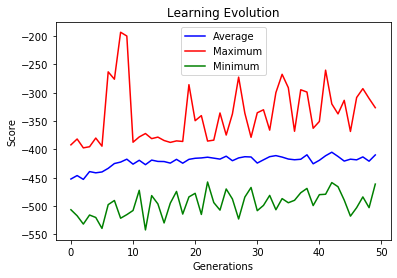

In [3]:
import matplotlib.pyplot as plt

def plotLearningEvolution(generationAverage, generationMax, generationMin):
    generationAverage = np.array(generationAverage)
    generationMax = np.array(generationMax)
    generationMin = np.array(generationMin)

    G = list(range(generationAverage.size))
    plt.title("Learning Evolution")
    plt.xlabel("Generations")
    plt.ylabel("Score")
    plt.plot(G, generationAverage, color='blue', label='Average')
    plt.plot(G, generationMax, color='red', label='Maximum')
    plt.plot(G, generationMin, color='green', label='Minimum')
    plt.legend()
    plt.show()

plotLearningEvolution(generationAverage, generationMax, generationMin)

Agora, vamos executar 5 gerações para o layout mediumClassic:

In [4]:
generation = createGeneration()
generationAverage, generationMax, generationMin, mediumClassicStrategy = runGeneticLearning("mediumClassic", generation)

layout:  mediumClassic



======== STARTING GENERATION 0 ========



Pacman died! Score: -494
Pacman died! Score: -506
Pacman died! Score: -489
Average Score: -496.3333333333333
Scores:        -494.0, -506.0, -489.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -588
Pacman died! Score: -497
Pacman died! Score: -531
Average Score: -538.6666666666666
Scores:        -588.0, -497.0, -531.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -559
Pacman died! Score: -490
Pacman died! Score: -503
Average Score: -517.3333333333334
Scores:        -559.0, -490.0, -503.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -640
Pacman died! Score: -578
Pacman died! Score: -582
Average Score: -600.0
Scores:        -640.0, -578.0, -582.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -371
Pacman died! Score: -439
Pacman died! Score: -393
Average Score: -401.0
Scores:        -371.0, -43

Pacman died! Score: -526
Pacman died! Score: -592
Pacman died! Score: -477
Average Score: -531.6666666666666
Scores:        -526.0, -592.0, -477.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -500
Pacman died! Score: -478
Pacman died! Score: -545
Average Score: -507.6666666666667
Scores:        -500.0, -478.0, -545.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -602
Pacman died! Score: -504
Pacman died! Score: -490
Average Score: -532.0
Scores:        -602.0, -504.0, -490.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -532
Pacman died! Score: -535
Pacman died! Score: -531
Average Score: -532.6666666666666
Scores:        -532.0, -535.0, -531.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -399
Pacman died! Score: -390
Pacman died! Score: -386
Average Score: -391.6666666666667
Scores:        -399.0, -390.0, -386.0
Win Rate:      0/3 (0.00)
Record:        Loss

Pacman died! Score: -196
Pacman died! Score: -488
Pacman died! Score: -527
Average Score: -403.6666666666667
Scores:        -196.0, -488.0, -527.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -478
Pacman died! Score: -216
Pacman died! Score: -508
Average Score: -400.6666666666667
Scores:        -478.0, -216.0, -508.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -410
Pacman died! Score: -311
Pacman died! Score: -386
Average Score: -369.0
Scores:        -410.0, -311.0, -386.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -614
Pacman died! Score: -576
Pacman died! Score: -554
Average Score: -581.3333333333334
Scores:        -614.0, -576.0, -554.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -343
Pacman died! Score: -380
Pacman died! Score: -419
Average Score: -380.6666666666667
Scores:        -343.0, -380.0, -419.0
Win Rate:      0/3 (0.00)
Record:        Loss

Pacman died! Score: -586
Average Score: -524.6666666666666
Scores:        -469.0, -519.0, -586.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -496
Pacman died! Score: -495
Pacman died! Score: -499
Average Score: -496.6666666666667
Scores:        -496.0, -495.0, -499.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -534
Pacman died! Score: -374
Pacman died! Score: -344
Average Score: -417.3333333333333
Scores:        -534.0, -374.0, -344.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -556
Pacman died! Score: -524
Pacman died! Score: -515
Average Score: -531.6666666666666
Scores:        -556.0, -524.0, -515.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -420
Pacman died! Score: -468
Pacman died! Score: -483
Average Score: -457.0
Scores:        -420.0, -468.0, -483.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -477
Pacman died!

Pacman died! Score: -398
Pacman died! Score: -377
Pacman died! Score: -278
Average Score: -351.0
Scores:        -398.0, -377.0, -278.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -408
Pacman died! Score: -356
Pacman died! Score: -336
Average Score: -366.6666666666667
Scores:        -408.0, -356.0, -336.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -377
Pacman died! Score: -364
Pacman died! Score: -355
Average Score: -365.3333333333333
Scores:        -377.0, -364.0, -355.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -479
Pacman died! Score: -602
Pacman died! Score: -463
Average Score: -514.6666666666666
Scores:        -479.0, -602.0, -463.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -410
Pacman died! Score: -388
Pacman died! Score: -422
Average Score: -406.6666666666667
Scores:        -410.0, -388.0, -422.0
Win Rate:      0/3 (0.00)
Record:        Loss

Pacman died! Score: -439
Pacman died! Score: -348
Pacman died! Score: -368
Average Score: -385.0
Scores:        -439.0, -348.0, -368.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -356
Pacman died! Score: -413
Pacman died! Score: -347
Average Score: -372.0
Scores:        -356.0, -413.0, -347.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -392
Pacman died! Score: -410
Pacman died! Score: -395
Average Score: -399.0
Scores:        -392.0, -410.0, -395.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -353
Pacman died! Score: -357
Pacman died! Score: -343
Average Score: -351.0
Scores:        -353.0, -357.0, -343.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -479
Pacman died! Score: -471
Pacman died! Score: -485
Average Score: -478.3333333333333
Scores:        -479.0, -471.0, -485.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -38

Pacman died! Score: -485
Pacman died! Score: -537
Pacman died! Score: -469
Average Score: -497.0
Scores:        -485.0, -537.0, -469.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -494
Pacman died! Score: -558
Pacman died! Score: -499
Average Score: -517.0
Scores:        -494.0, -558.0, -499.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -394
Pacman died! Score: -436
Pacman died! Score: -473
Average Score: -434.3333333333333
Scores:        -394.0, -436.0, -473.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -465
Pacman died! Score: -453
Pacman died! Score: -544
Average Score: -487.3333333333333
Scores:        -465.0, -453.0, -544.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -454
Pacman died! Score: -492
Pacman died! Score: -449
Average Score: -465.0
Scores:        -454.0, -492.0, -449.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss



========

Pacman died! Score: -338
Pacman died! Score: -436
Pacman died! Score: -365
Average Score: -379.6666666666667
Scores:        -338.0, -436.0, -365.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -412
Pacman died! Score: -401
Pacman died! Score: -574
Average Score: -462.3333333333333
Scores:        -412.0, -401.0, -574.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -440
Pacman died! Score: -487
Pacman died! Score: -509
Average Score: -478.6666666666667
Scores:        -440.0, -487.0, -509.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -373
Pacman died! Score: -383
Pacman died! Score: -457
Average Score: -404.3333333333333
Scores:        -373.0, -383.0, -457.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -493
Pacman died! Score: -469
Pacman died! Score: -479
Average Score: -480.3333333333333
Scores:        -493.0, -469.0, -479.0
Win Rate:      0/3 (0.00)
Record:

Pacman died! Score: -343
Average Score: -378.6666666666667
Scores:        -432.0, -361.0, -343.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -610
Pacman died! Score: -499
Pacman died! Score: -480
Average Score: -529.6666666666666
Scores:        -610.0, -499.0, -480.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -410
Pacman died! Score: -390
Pacman died! Score: -400
Average Score: -400.0
Scores:        -410.0, -390.0, -400.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -485
Pacman died! Score: -546
Pacman died! Score: -495
Average Score: -508.6666666666667
Scores:        -485.0, -546.0, -495.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -388
Pacman died! Score: -365
Pacman died! Score: -426
Average Score: -393.0
Scores:        -388.0, -365.0, -426.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -387
Pacman died! Score: -394

Pacman died! Score: -387
Pacman died! Score: -390
Pacman died! Score: -334
Average Score: -370.3333333333333
Scores:        -387.0, -390.0, -334.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -430
Pacman died! Score: -385
Pacman died! Score: -418
Average Score: -411.0
Scores:        -430.0, -385.0, -418.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -396
Pacman died! Score: -425
Pacman died! Score: -446
Average Score: -422.3333333333333
Scores:        -396.0, -425.0, -446.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -409
Pacman died! Score: -419
Pacman died! Score: -407
Average Score: -411.6666666666667
Scores:        -409.0, -419.0, -407.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -410
Pacman died! Score: -372
Pacman died! Score: -419
Average Score: -400.3333333333333
Scores:        -410.0, -372.0, -419.0
Win Rate:      0/3 (0.00)
Record:        Loss

Pacman died! Score: -378
Pacman died! Score: -391
Pacman died! Score: -396
Average Score: -388.3333333333333
Scores:        -378.0, -391.0, -396.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -555
Pacman died! Score: -445
Pacman died! Score: -403
Average Score: -467.6666666666667
Scores:        -555.0, -445.0, -403.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -439
Pacman died! Score: -416
Pacman died! Score: -403
Average Score: -419.3333333333333
Scores:        -439.0, -416.0, -403.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -393
Pacman died! Score: -417
Pacman died! Score: -563
Average Score: -457.6666666666667
Scores:        -393.0, -417.0, -563.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -668
Pacman died! Score: -524
Pacman died! Score: -489
Average Score: -560.3333333333334
Scores:        -668.0, -524.0, -489.0
Win Rate:      0/3 (0.00)
Record:

Pacman died! Score: -392
Pacman died! Score: -428
Pacman died! Score: -431
Average Score: -417.0
Scores:        -392.0, -428.0, -431.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss



======== STARTING GENERATION 9 ========



Pacman died! Score: -348
Pacman died! Score: -474
Pacman died! Score: -382
Average Score: -401.3333333333333
Scores:        -348.0, -474.0, -382.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -468
Pacman died! Score: -419
Pacman died! Score: -419
Average Score: -435.3333333333333
Scores:        -468.0, -419.0, -419.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -384
Pacman died! Score: -389
Pacman died! Score: -390
Average Score: -387.6666666666667
Scores:        -384.0, -389.0, -390.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -410
Pacman died! Score: -401
Pacman died! Score: -363
Average Score: -391.3333333333333
Scores:        -410.0, -401.0, -363.0

Pacman died! Score: -406
Pacman died! Score: -410
Pacman died! Score: -410
Average Score: -408.6666666666667
Scores:        -406.0, -410.0, -410.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -545
Pacman died! Score: -506
Pacman died! Score: -513
Average Score: -521.3333333333334
Scores:        -545.0, -506.0, -513.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -366
Pacman died! Score: -385
Pacman died! Score: -355
Average Score: -368.6666666666667
Scores:        -366.0, -385.0, -355.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -410
Pacman died! Score: -374
Pacman died! Score: -410
Average Score: -398.0
Scores:        -410.0, -374.0, -410.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -606
Pacman died! Score: -352
Pacman died! Score: -648
Average Score: -535.3333333333334
Scores:        -606.0, -352.0, -648.0
Win Rate:      0/3 (0.00)
Record:        Loss

Pacman died! Score: -451
Pacman died! Score: -430
Pacman died! Score: -411
Average Score: -430.6666666666667
Scores:        -451.0, -430.0, -411.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -476
Pacman died! Score: -519
Pacman died! Score: -478
Average Score: -491.0
Scores:        -476.0, -519.0, -478.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -428
Pacman died! Score: -398
Pacman died! Score: -410
Average Score: -412.0
Scores:        -428.0, -398.0, -410.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -385
Pacman died! Score: -389
Pacman died! Score: -419
Average Score: -397.6666666666667
Scores:        -385.0, -389.0, -419.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -382
Pacman died! Score: -396
Pacman died! Score: -303
Average Score: -360.3333333333333
Scores:        -382.0, -396.0, -303.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss

Pacman died! Score: -389
Pacman died! Score: -365
Average Score: -391.0
Scores:        -419.0, -389.0, -365.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -397
Pacman died! Score: -188
Pacman died! Score: -296
Average Score: -293.6666666666667
Scores:        -397.0, -188.0, -296.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -393
Pacman died! Score: -422
Pacman died! Score: -561
Average Score: -458.6666666666667
Scores:        -393.0, -422.0, -561.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -408
Pacman died! Score: -369
Pacman died! Score: -392
Average Score: -389.6666666666667
Scores:        -408.0, -369.0, -392.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -317
Pacman died! Score: -429
Pacman died! Score: -387
Average Score: -377.6666666666667
Scores:        -317.0, -429.0, -387.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died!

Pacman died! Score: -377
Pacman died! Score: -435
Pacman died! Score: -403
Average Score: -405.0
Scores:        -377.0, -435.0, -403.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -514
Pacman died! Score: -622
Pacman died! Score: -637
Average Score: -591.0
Scores:        -514.0, -622.0, -637.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -410
Pacman died! Score: -389
Pacman died! Score: -384
Average Score: -394.3333333333333
Scores:        -410.0, -389.0, -384.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -391
Pacman died! Score: -410
Pacman died! Score: -431
Average Score: -410.6666666666667
Scores:        -391.0, -410.0, -431.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -397
Pacman died! Score: -460
Pacman died! Score: -400
Average Score: -419.0
Scores:        -397.0, -460.0, -400.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died

Pacman died! Score: -350
Pacman died! Score: -506
Pacman died! Score: -435
Average Score: -430.3333333333333
Scores:        -350.0, -506.0, -435.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -397
Pacman died! Score: -433
Pacman died! Score: -377
Average Score: -402.3333333333333
Scores:        -397.0, -433.0, -377.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -394
Pacman died! Score: -384
Pacman died! Score: -365
Average Score: -381.0
Scores:        -394.0, -384.0, -365.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -356
Pacman died! Score: -385
Pacman died! Score: -401
Average Score: -380.6666666666667
Scores:        -356.0, -385.0, -401.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -385
Pacman died! Score: -419
Pacman died! Score: -272
Average Score: -358.6666666666667
Scores:        -385.0, -419.0, -272.0
Win Rate:      0/3 (0.00)
Record:        Loss

Pacman died! Score: -407
Pacman died! Score: -431
Pacman died! Score: -418
Average Score: -418.6666666666667
Scores:        -407.0, -431.0, -418.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -373
Pacman died! Score: -348
Pacman died! Score: -391
Average Score: -370.6666666666667
Scores:        -373.0, -348.0, -391.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -428
Pacman died! Score: -489
Pacman died! Score: -388
Average Score: -435.0
Scores:        -428.0, -489.0, -388.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -419
Pacman died! Score: -410
Pacman died! Score: -410
Average Score: -413.0
Scores:        -419.0, -410.0, -410.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -413
Pacman died! Score: -342
Pacman died! Score: -497
Average Score: -417.3333333333333
Scores:        -413.0, -342.0, -497.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss

Pacman died! Score: -417
Pacman died! Score: -402
Average Score: -414.0
Scores:        -423.0, -417.0, -402.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -394
Pacman died! Score: -399
Pacman died! Score: -419
Average Score: -404.0
Scores:        -394.0, -399.0, -419.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -464
Pacman died! Score: -413
Pacman died! Score: -419
Average Score: -432.0
Scores:        -464.0, -413.0, -419.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -381
Pacman died! Score: -365
Pacman died! Score: -390
Average Score: -378.6666666666667
Scores:        -381.0, -365.0, -390.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -365
Pacman died! Score: -389
Pacman died! Score: -351
Average Score: -368.3333333333333
Scores:        -365.0, -389.0, -351.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -393
Pacman died

Pacman died! Score: -401
Pacman died! Score: -428
Pacman died! Score: -401
Average Score: -410.0
Scores:        -401.0, -428.0, -401.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -401
Pacman died! Score: -410
Pacman died! Score: -410
Average Score: -407.0
Scores:        -401.0, -410.0, -410.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -342
Pacman died! Score: -359
Pacman died! Score: -347
Average Score: -349.3333333333333
Scores:        -342.0, -359.0, -347.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -424
Pacman died! Score: -382
Pacman died! Score: -136
Average Score: -314.0
Scores:        -424.0, -382.0, -136.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -343
Pacman died! Score: -382
Pacman died! Score: -334
Average Score: -353.0
Scores:        -343.0, -382.0, -334.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -51

Pacman died! Score: -427
Pacman died! Score: -401
Pacman died! Score: -563
Average Score: -463.6666666666667
Scores:        -427.0, -401.0, -563.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -470
Pacman died! Score: -395
Pacman died! Score: -362
Average Score: -409.0
Scores:        -470.0, -395.0, -362.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -381
Pacman died! Score: -347
Pacman died! Score: -356
Average Score: -361.3333333333333
Scores:        -381.0, -347.0, -356.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -332
Pacman died! Score: -410
Pacman died! Score: -448
Average Score: -396.6666666666667
Scores:        -332.0, -410.0, -448.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -370
Pacman died! Score: -399
Pacman died! Score: -391
Average Score: -386.6666666666667
Scores:        -370.0, -399.0, -391.0
Win Rate:      0/3 (0.00)
Record:        Loss

Pacman died! Score: -433
Pacman died! Score: -169
Pacman died! Score: -413
Average Score: -338.3333333333333
Scores:        -433.0, -169.0, -413.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -423
Pacman died! Score: -357
Pacman died! Score: -334
Average Score: -371.3333333333333
Scores:        -423.0, -357.0, -334.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -410
Pacman died! Score: -428
Pacman died! Score: -390
Average Score: -409.3333333333333
Scores:        -410.0, -428.0, -390.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -410
Pacman died! Score: -401
Pacman died! Score: -466
Average Score: -425.6666666666667
Scores:        -410.0, -401.0, -466.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -354
Pacman died! Score: -371
Pacman died! Score: -556
Average Score: -427.0
Scores:        -354.0, -371.0, -556.0
Win Rate:      0/3 (0.00)
Record:        Loss

Pacman died! Score: -346
Pacman died! Score: -369
Pacman died! Score: -439
Average Score: -384.6666666666667
Scores:        -346.0, -369.0, -439.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -356
Pacman died! Score: -375
Pacman died! Score: -348
Average Score: -359.6666666666667
Scores:        -356.0, -375.0, -348.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -392
Pacman died! Score: -404
Pacman died! Score: -386
Average Score: -394.0
Scores:        -392.0, -404.0, -386.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -355
Pacman died! Score: -533
Pacman died! Score: -429
Average Score: -439.0
Scores:        -355.0, -533.0, -429.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -360
Pacman died! Score: -364
Pacman died! Score: -526
Average Score: -416.6666666666667
Scores:        -360.0, -364.0, -526.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss

Pacman died! Score: -434
Pacman died! Score: -393
Pacman died! Score: -380
Average Score: -402.3333333333333
Scores:        -434.0, -393.0, -380.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -356
Pacman died! Score: -384
Pacman died! Score: -356
Average Score: -365.3333333333333
Scores:        -356.0, -384.0, -356.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -494
Pacman died! Score: -401
Pacman died! Score: -345
Average Score: -413.3333333333333
Scores:        -494.0, -401.0, -345.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -384
Pacman died! Score: -345
Pacman died! Score: -357
Average Score: -362.0
Scores:        -384.0, -345.0, -357.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -445
Pacman died! Score: -336
Pacman died! Score: -386
Average Score: -389.0
Scores:        -445.0, -336.0, -386.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss

Pacman died! Score: -360
Pacman died! Score: -526
Pacman died! Score: -413
Average Score: -433.0
Scores:        -360.0, -526.0, -413.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -342
Pacman died! Score: -461
Pacman died! Score: -547
Average Score: -450.0
Scores:        -342.0, -461.0, -547.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -356
Pacman died! Score: -411
Pacman died! Score: -466
Average Score: -411.0
Scores:        -356.0, -411.0, -466.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -347
Pacman died! Score: -370
Pacman died! Score: -348
Average Score: -355.0
Scores:        -347.0, -370.0, -348.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -344
Pacman died! Score: -389
Pacman died! Score: -356
Average Score: -363.0
Scores:        -344.0, -389.0, -356.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -454
Pacman die

Pacman died! Score: -496
Pacman died! Score: -378
Pacman died! Score: -422
Average Score: -432.0
Scores:        -496.0, -378.0, -422.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -375
Pacman died! Score: -390
Pacman died! Score: -373
Average Score: -379.3333333333333
Scores:        -375.0, -390.0, -373.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -412
Pacman died! Score: -384
Pacman died! Score: -389
Average Score: -395.0
Scores:        -412.0, -384.0, -389.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -386
Pacman died! Score: -387
Pacman died! Score: -439
Average Score: -404.0
Scores:        -386.0, -387.0, -439.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -369
Pacman died! Score: -353
Pacman died! Score: -426
Average Score: -382.6666666666667
Scores:        -369.0, -353.0, -426.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died

Pacman died! Score: -435
Pacman died! Score: -401
Pacman died! Score: -330
Average Score: -388.6666666666667
Scores:        -435.0, -401.0, -330.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -173
Pacman died! Score: -440
Pacman died! Score: -166
Average Score: -259.6666666666667
Scores:        -173.0, -440.0, -166.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -385
Pacman died! Score: -525
Pacman died! Score: -403
Average Score: -437.6666666666667
Scores:        -385.0, -525.0, -403.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -456
Pacman died! Score: -381
Pacman died! Score: -504
Average Score: -447.0
Scores:        -456.0, -381.0, -504.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -420
Pacman died! Score: -382
Pacman died! Score: -432
Average Score: -411.3333333333333
Scores:        -420.0, -382.0, -432.0
Win Rate:      0/3 (0.00)
Record:        Loss

Pacman died! Score: -434
Pacman died! Score: -399
Average Score: -396.3333333333333
Scores:        -356.0, -434.0, -399.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -469
Pacman died! Score: -392
Pacman died! Score: -393
Average Score: -418.0
Scores:        -469.0, -392.0, -393.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -600
Pacman died! Score: -354
Pacman died! Score: -365
Average Score: -439.6666666666667
Scores:        -600.0, -354.0, -365.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -343
Pacman died! Score: -382
Pacman died! Score: -432
Average Score: -385.6666666666667
Scores:        -343.0, -382.0, -432.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -429
Pacman died! Score: -438
Pacman died! Score: -431
Average Score: -432.6666666666667
Scores:        -429.0, -438.0, -431.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died!

Pacman died! Score: -391
Pacman died! Score: -385
Pacman died! Score: -428
Average Score: -401.3333333333333
Scores:        -391.0, -385.0, -428.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -355
Pacman died! Score: -340
Pacman died! Score: -549
Average Score: -414.6666666666667
Scores:        -355.0, -340.0, -549.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -401
Pacman died! Score: -378
Pacman died! Score: -388
Average Score: -389.0
Scores:        -401.0, -378.0, -388.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -672
Pacman died! Score: -440
Pacman died! Score: -418
Average Score: -510.0
Scores:        -672.0, -440.0, -418.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss



======== STARTING GENERATION 23 ========



Pacman died! Score: -406
Pacman died! Score: -406
Pacman died! Score: -421
Average Score: -411.0
Scores:        -406.0, -406.0, -421.0
Win Rate:      0/3 (0.

Pacman died! Score: -537
Pacman died! Score: -527
Pacman died! Score: -488
Average Score: -517.3333333333334
Scores:        -537.0, -527.0, -488.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -550
Pacman died! Score: -493
Pacman died! Score: -483
Average Score: -508.6666666666667
Scores:        -550.0, -493.0, -483.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -418
Pacman died! Score: -352
Pacman died! Score: -450
Average Score: -406.6666666666667
Scores:        -418.0, -352.0, -450.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -132
Pacman died! Score: -363
Pacman died! Score: -381
Average Score: -292.0
Scores:        -132.0, -363.0, -381.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -317
Pacman died! Score: -369
Pacman died! Score: -433
Average Score: -373.0
Scores:        -317.0, -369.0, -433.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss

Pacman died! Score: -382
Pacman died! Score: -486
Pacman died! Score: -391
Average Score: -419.6666666666667
Scores:        -382.0, -486.0, -391.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -358
Pacman died! Score: -368
Pacman died! Score: -401
Average Score: -375.6666666666667
Scores:        -358.0, -368.0, -401.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -426
Pacman died! Score: -539
Pacman died! Score: -499
Average Score: -488.0
Scores:        -426.0, -539.0, -499.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -349
Pacman died! Score: -535
Pacman died! Score: -351
Average Score: -411.6666666666667
Scores:        -349.0, -535.0, -351.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -360
Pacman died! Score: -47
Pacman died! Score: -361
Average Score: -256.0
Scores:        -360.0, -47.0, -361.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
P

Pacman died! Score: -432
Pacman died! Score: -476
Pacman died! Score: -450
Average Score: -452.6666666666667
Scores:        -432.0, -476.0, -450.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -248
Pacman died! Score: -199
Pacman died! Score: -149
Average Score: -198.66666666666666
Scores:        -248.0, -199.0, -149.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -401
Pacman died! Score: -368
Pacman died! Score: -387
Average Score: -385.3333333333333
Scores:        -401.0, -368.0, -387.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -385
Pacman died! Score: -426
Pacman died! Score: -340
Average Score: -383.6666666666667
Scores:        -385.0, -426.0, -340.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -393
Pacman died! Score: -422
Pacman died! Score: -418
Average Score: -411.0
Scores:        -393.0, -422.0, -418.0
Win Rate:      0/3 (0.00)
Record:        Los

Pacman died! Score: -378
Pacman died! Score: -377
Pacman died! Score: -356
Average Score: -370.3333333333333
Scores:        -378.0, -377.0, -356.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -401
Pacman died! Score: -339
Pacman died! Score: -722
Average Score: -487.3333333333333
Scores:        -401.0, -339.0, -722.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -452
Pacman died! Score: -451
Pacman died! Score: -372
Average Score: -425.0
Scores:        -452.0, -451.0, -372.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -519
Pacman died! Score: -385
Pacman died! Score: -356
Average Score: -420.0
Scores:        -519.0, -385.0, -356.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -221
Pacman died! Score: -408
Pacman died! Score: -414
Average Score: -347.6666666666667
Scores:        -221.0, -408.0, -414.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss

Pacman died! Score: -354
Pacman died! Score: -343
Pacman died! Score: -387
Average Score: -361.3333333333333
Scores:        -354.0, -343.0, -387.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -453
Pacman died! Score: -396
Pacman died! Score: -387
Average Score: -412.0
Scores:        -453.0, -396.0, -387.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -440
Pacman died! Score: -400
Pacman died! Score: -356
Average Score: -398.6666666666667
Scores:        -440.0, -400.0, -356.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -375
Pacman died! Score: -344
Pacman died! Score: -425
Average Score: -381.3333333333333
Scores:        -375.0, -344.0, -425.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -411
Pacman died! Score: -366
Pacman died! Score: -357
Average Score: -378.0
Scores:        -411.0, -366.0, -357.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss

Pacman died! Score: -371
Pacman died! Score: -329
Pacman died! Score: -351
Average Score: -350.3333333333333
Scores:        -371.0, -329.0, -351.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -394
Pacman died! Score: -355
Pacman died! Score: -389
Average Score: -379.3333333333333
Scores:        -394.0, -355.0, -389.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -363
Pacman died! Score: -376
Pacman died! Score: -401
Average Score: -380.0
Scores:        -363.0, -376.0, -401.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -343
Pacman died! Score: -359
Pacman died! Score: -460
Average Score: -387.3333333333333
Scores:        -343.0, -359.0, -460.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -661
Pacman died! Score: -426
Pacman died! Score: -343
Average Score: -476.6666666666667
Scores:        -661.0, -426.0, -343.0
Win Rate:      0/3 (0.00)
Record:        Loss

Pacman died! Score: -445
Pacman died! Score: -349
Average Score: -398.3333333333333
Scores:        -401.0, -445.0, -349.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -367
Pacman died! Score: -394
Pacman died! Score: -392
Average Score: -384.3333333333333
Scores:        -367.0, -394.0, -392.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -466
Pacman died! Score: -486
Pacman died! Score: -430
Average Score: -460.6666666666667
Scores:        -466.0, -486.0, -430.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -413
Pacman died! Score: -353
Pacman died! Score: -417
Average Score: -394.3333333333333
Scores:        -413.0, -353.0, -417.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -432
Pacman died! Score: -401
Pacman died! Score: -346
Average Score: -393.0
Scores:        -432.0, -401.0, -346.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died!

Pacman died! Score: -372
Pacman died! Score: -405
Pacman died! Score: -5
Average Score: -260.6666666666667
Scores:        -372.0, -405.0, -5.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -546
Pacman died! Score: -357
Pacman died! Score: -350
Average Score: -417.6666666666667
Scores:        -546.0, -357.0, -350.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -371
Pacman died! Score: -393
Pacman died! Score: -379
Average Score: -381.0
Scores:        -371.0, -393.0, -379.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -377
Pacman died! Score: -385
Pacman died! Score: -389
Average Score: -383.6666666666667
Scores:        -377.0, -385.0, -389.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -398
Pacman died! Score: -413
Pacman died! Score: -413
Average Score: -408.0
Scores:        -398.0, -413.0, -413.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pac

Pacman died! Score: -410
Pacman died! Score: -385
Pacman died! Score: -428
Average Score: -407.6666666666667
Scores:        -410.0, -385.0, -428.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -493
Pacman died! Score: -399
Pacman died! Score: -358
Average Score: -416.6666666666667
Scores:        -493.0, -399.0, -358.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -378
Pacman died! Score: -382
Pacman died! Score: -410
Average Score: -390.0
Scores:        -378.0, -382.0, -410.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -386
Pacman died! Score: -527
Pacman died! Score: -391
Average Score: -434.6666666666667
Scores:        -386.0, -527.0, -391.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -475
Pacman died! Score: -352
Pacman died! Score: -412
Average Score: -413.0
Scores:        -475.0, -352.0, -412.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss

Pacman died! Score: -412
Pacman died! Score: -432
Pacman died! Score: -428
Average Score: -424.0
Scores:        -412.0, -432.0, -428.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -457
Pacman died! Score: -456
Pacman died! Score: -354
Average Score: -422.3333333333333
Scores:        -457.0, -456.0, -354.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -399
Pacman died! Score: -387
Pacman died! Score: -413
Average Score: -399.6666666666667
Scores:        -399.0, -387.0, -413.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -419
Pacman died! Score: -348
Pacman died! Score: -484
Average Score: -417.0
Scores:        -419.0, -348.0, -484.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -556
Pacman died! Score: -340
Pacman died! Score: -394
Average Score: -430.0
Scores:        -556.0, -340.0, -394.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died

Pacman died! Score: -399
Pacman died! Score: -406
Average Score: -408.3333333333333
Scores:        -420.0, -399.0, -406.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -366
Pacman died! Score: -570
Pacman died! Score: -420
Average Score: -452.0
Scores:        -366.0, -570.0, -420.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -400
Pacman died! Score: -428
Pacman died! Score: -645
Average Score: -491.0
Scores:        -400.0, -428.0, -645.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss



======== STARTING GENERATION 32 ========



Pacman died! Score: -410
Pacman died! Score: -377
Pacman died! Score: -428
Average Score: -405.0
Scores:        -410.0, -377.0, -428.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -419
Pacman died! Score: -385
Pacman died! Score: -410
Average Score: -404.6666666666667
Scores:        -419.0, -385.0, -410.0
Win Rate:      0/3 (0.00)
Record:        Loss, 

Pacman died! Score: -377
Pacman died! Score: -401
Pacman died! Score: -361
Average Score: -379.6666666666667
Scores:        -377.0, -401.0, -361.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -386
Pacman died! Score: -392
Pacman died! Score: -393
Average Score: -390.3333333333333
Scores:        -386.0, -392.0, -393.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -386
Pacman died! Score: -442
Pacman died! Score: -356
Average Score: -394.6666666666667
Scores:        -386.0, -442.0, -356.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -443
Pacman died! Score: -359
Pacman died! Score: -415
Average Score: -405.6666666666667
Scores:        -443.0, -359.0, -415.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -380
Pacman died! Score: -357
Pacman died! Score: -373
Average Score: -370.0
Scores:        -380.0, -357.0, -373.0
Win Rate:      0/3 (0.00)
Record:        Loss

Pacman died! Score: -432
Pacman died! Score: -394
Pacman died! Score: -352
Average Score: -392.6666666666667
Scores:        -432.0, -394.0, -352.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -452
Pacman died! Score: -454
Pacman died! Score: -393
Average Score: -433.0
Scores:        -452.0, -454.0, -393.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -401
Pacman died! Score: -407
Pacman died! Score: -409
Average Score: -405.6666666666667
Scores:        -401.0, -407.0, -409.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -730
Pacman died! Score: -420
Pacman died! Score: -381
Average Score: -510.3333333333333
Scores:        -730.0, -420.0, -381.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -637
Pacman died! Score: -402
Pacman died! Score: -422
Average Score: -487.0
Scores:        -637.0, -402.0, -422.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss

Pacman died! Score: -408
Pacman died! Score: -369
Average Score: -380.6666666666667
Scores:        -365.0, -408.0, -369.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -397
Pacman died! Score: -339
Pacman died! Score: -415
Average Score: -383.6666666666667
Scores:        -397.0, -339.0, -415.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -504
Pacman died! Score: -585
Pacman died! Score: -416
Average Score: -501.6666666666667
Scores:        -504.0, -585.0, -416.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -623
Pacman died! Score: -356
Pacman died! Score: -351
Average Score: -443.3333333333333
Scores:        -623.0, -356.0, -351.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -347
Pacman died! Score: -346
Pacman died! Score: -396
Average Score: -363.0
Scores:        -347.0, -346.0, -396.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died!

Pacman died! Score: -459
Pacman died! Score: -433
Pacman died! Score: -447
Average Score: -446.3333333333333
Scores:        -459.0, -433.0, -447.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -454
Pacman died! Score: -419
Pacman died! Score: -504
Average Score: -459.0
Scores:        -454.0, -419.0, -504.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -431
Pacman died! Score: -363
Pacman died! Score: -412
Average Score: -402.0
Scores:        -431.0, -363.0, -412.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -570
Pacman died! Score: -423
Pacman died! Score: -365
Average Score: -452.6666666666667
Scores:        -570.0, -423.0, -365.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -366
Pacman died! Score: -401
Pacman died! Score: -373
Average Score: -380.0
Scores:        -366.0, -401.0, -373.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died

Pacman died! Score: -480
Pacman died! Score: -398
Average Score: -426.3333333333333
Scores:        -401.0, -480.0, -398.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -594
Pacman died! Score: -371
Pacman died! Score: -416
Average Score: -460.3333333333333
Scores:        -594.0, -371.0, -416.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -359
Pacman died! Score: -359
Pacman died! Score: -388
Average Score: -368.6666666666667
Scores:        -359.0, -359.0, -388.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -357
Pacman died! Score: -401
Pacman died! Score: -365
Average Score: -374.3333333333333
Scores:        -357.0, -401.0, -365.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -356
Pacman died! Score: -422
Pacman died! Score: -356
Average Score: -378.0
Scores:        -356.0, -422.0, -356.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died!

Pacman died! Score: -342
Pacman died! Score: -452
Pacman died! Score: -365
Average Score: -386.3333333333333
Scores:        -342.0, -452.0, -365.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -376
Pacman died! Score: -417
Pacman died! Score: -377
Average Score: -390.0
Scores:        -376.0, -417.0, -377.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -400
Pacman died! Score: -429
Pacman died! Score: -218
Average Score: -349.0
Scores:        -400.0, -429.0, -218.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -386
Pacman died! Score: -400
Pacman died! Score: -401
Average Score: -395.6666666666667
Scores:        -386.0, -400.0, -401.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -356
Pacman died! Score: -380
Pacman died! Score: -411
Average Score: -382.3333333333333
Scores:        -356.0, -380.0, -411.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss

Pacman died! Score: -347
Pacman died! Score: -370
Pacman died! Score: -389
Average Score: -368.6666666666667
Scores:        -347.0, -370.0, -389.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: 41
Pacman died! Score: -248
Pacman died! Score: -361
Average Score: -189.33333333333334
Scores:        41.0, -248.0, -361.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -378
Pacman died! Score: -389
Pacman died! Score: -394
Average Score: -387.0
Scores:        -378.0, -389.0, -394.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -543
Pacman died! Score: -201
Pacman died! Score: -401
Average Score: -381.6666666666667
Scores:        -543.0, -201.0, -401.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -356
Pacman died! Score: -397
Pacman died! Score: -348
Average Score: -367.0
Scores:        -356.0, -397.0, -348.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pa

Pacman died! Score: -349
Pacman died! Score: -342
Pacman died! Score: -376
Average Score: -355.6666666666667
Scores:        -349.0, -342.0, -376.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -426
Pacman died! Score: -440
Pacman died! Score: -547
Average Score: -471.0
Scores:        -426.0, -440.0, -547.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -365
Pacman died! Score: -385
Pacman died! Score: -345
Average Score: -365.0
Scores:        -365.0, -385.0, -345.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -401
Pacman died! Score: -484
Pacman died! Score: -452
Average Score: -445.6666666666667
Scores:        -401.0, -484.0, -452.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -460
Pacman died! Score: -608
Pacman died! Score: -679
Average Score: -582.3333333333334
Scores:        -460.0, -608.0, -679.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss

Pacman died! Score: -342
Pacman died! Score: -376
Pacman died! Score: -374
Average Score: -364.0
Scores:        -342.0, -376.0, -374.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -409
Pacman died! Score: -496
Pacman died! Score: -492
Average Score: -465.6666666666667
Scores:        -409.0, -496.0, -492.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -466
Pacman died! Score: -516
Pacman died! Score: -472
Average Score: -484.6666666666667
Scores:        -466.0, -516.0, -472.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -396
Pacman died! Score: -413
Pacman died! Score: -392
Average Score: -400.3333333333333
Scores:        -396.0, -413.0, -392.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -187
Pacman died! Score: -175
Pacman died! Score: -171
Average Score: -177.66666666666666
Scores:        -187.0, -175.0, -171.0
Win Rate:      0/3 (0.00)
Record:        Los

Pacman died! Score: -449
Pacman died! Score: -347
Pacman died! Score: -440
Average Score: -412.0
Scores:        -449.0, -347.0, -440.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -532
Pacman died! Score: -410
Pacman died! Score: -386
Average Score: -442.6666666666667
Scores:        -532.0, -410.0, -386.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -377
Pacman died! Score: -433
Pacman died! Score: -660
Average Score: -490.0
Scores:        -377.0, -433.0, -660.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -427
Pacman died! Score: -399
Pacman died! Score: -204
Average Score: -343.3333333333333
Scores:        -427.0, -399.0, -204.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -446
Pacman died! Score: -566
Pacman died! Score: -443
Average Score: -485.0
Scores:        -446.0, -566.0, -443.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died

Pacman died! Score: -406
Pacman died! Score: -391
Average Score: -399.3333333333333
Scores:        -401.0, -406.0, -391.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -358
Pacman died! Score: -347
Pacman died! Score: -540
Average Score: -415.0
Scores:        -358.0, -347.0, -540.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss



======== STARTING GENERATION 41 ========



Pacman died! Score: -474
Pacman died! Score: -430
Pacman died! Score: -234
Average Score: -379.3333333333333
Scores:        -474.0, -430.0, -234.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -382
Pacman died! Score: 22
Pacman died! Score: -424
Average Score: -261.3333333333333
Scores:        -382.0, 22.0, -424.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -473
Pacman died! Score: -444
Pacman died! Score: -509
Average Score: -475.3333333333333
Scores:        -473.0, -444.0, -509.0
Win Rate:      0/3 (0.00)
R

Pacman died! Score: -470
Pacman died! Score: -386
Pacman died! Score: -356
Average Score: -404.0
Scores:        -470.0, -386.0, -356.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -387
Pacman died! Score: -396
Pacman died! Score: -608
Average Score: -463.6666666666667
Scores:        -387.0, -396.0, -608.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -160
Pacman died! Score: -361
Pacman died! Score: -353
Average Score: -291.3333333333333
Scores:        -160.0, -361.0, -353.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -173
Pacman died! Score: -369
Pacman died! Score: -416
Average Score: -319.3333333333333
Scores:        -173.0, -369.0, -416.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -531
Pacman died! Score: -342
Pacman died! Score: -342
Average Score: -405.0
Scores:        -531.0, -342.0, -342.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss

Pacman died! Score: -404
Pacman died! Score: -410
Pacman died! Score: -384
Average Score: -399.3333333333333
Scores:        -404.0, -410.0, -384.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -425
Pacman died! Score: -354
Pacman died! Score: -419
Average Score: -399.3333333333333
Scores:        -425.0, -354.0, -419.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -416
Pacman died! Score: -392
Pacman died! Score: -394
Average Score: -400.6666666666667
Scores:        -416.0, -392.0, -394.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -415
Pacman died! Score: -421
Pacman died! Score: -399
Average Score: -411.6666666666667
Scores:        -415.0, -421.0, -399.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -371
Pacman died! Score: -370
Pacman died! Score: -375
Average Score: -372.0
Scores:        -371.0, -370.0, -375.0
Win Rate:      0/3 (0.00)
Record:        Loss

Pacman died! Score: -147
Pacman died! Score: -424
Pacman died! Score: -347
Average Score: -306.0
Scores:        -147.0, -424.0, -347.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -483
Pacman died! Score: -381
Pacman died! Score: -478
Average Score: -447.3333333333333
Scores:        -483.0, -381.0, -478.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -486
Pacman died! Score: -445
Pacman died! Score: -163
Average Score: -364.6666666666667
Scores:        -486.0, -445.0, -163.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -438
Pacman died! Score: -490
Pacman died! Score: -410
Average Score: -446.0
Scores:        -438.0, -490.0, -410.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -356
Pacman died! Score: -385
Pacman died! Score: -634
Average Score: -458.3333333333333
Scores:        -356.0, -385.0, -634.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss

Pacman died! Score: -384
Pacman died! Score: -357
Pacman died! Score: -386
Average Score: -375.6666666666667
Scores:        -384.0, -357.0, -386.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -217
Pacman died! Score: -537
Pacman died! Score: -461
Average Score: -405.0
Scores:        -217.0, -537.0, -461.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -409
Pacman died! Score: -367
Pacman died! Score: -443
Average Score: -406.3333333333333
Scores:        -409.0, -367.0, -443.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -420
Pacman died! Score: -393
Pacman died! Score: -467
Average Score: -426.6666666666667
Scores:        -420.0, -393.0, -467.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -358
Pacman died! Score: -414
Pacman died! Score: -356
Average Score: -376.0
Scores:        -358.0, -414.0, -356.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss

Pacman died! Score: -395
Pacman died! Score: -193
Pacman died! Score: -407
Average Score: -331.6666666666667
Scores:        -395.0, -193.0, -407.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -239
Pacman died! Score: -183
Pacman died! Score: -401
Average Score: -274.3333333333333
Scores:        -239.0, -183.0, -401.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -439
Pacman died! Score: -401
Pacman died! Score: -383
Average Score: -407.6666666666667
Scores:        -439.0, -401.0, -383.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -247
Pacman died! Score: -397
Pacman died! Score: -403
Average Score: -349.0
Scores:        -247.0, -397.0, -403.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -139
Pacman died! Score: -408
Pacman died! Score: -401
Average Score: -316.0
Scores:        -139.0, -408.0, -401.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss

Pacman died! Score: -354
Pacman died! Score: -519
Average Score: -428.3333333333333
Scores:        -412.0, -354.0, -519.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -500
Pacman died! Score: -353
Pacman died! Score: -363
Average Score: -405.3333333333333
Scores:        -500.0, -353.0, -363.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -410
Pacman died! Score: -377
Pacman died! Score: -480
Average Score: -422.3333333333333
Scores:        -410.0, -377.0, -480.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -410
Pacman died! Score: -459
Pacman died! Score: -395
Average Score: -421.3333333333333
Scores:        -410.0, -459.0, -395.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -201
Pacman died! Score: -348
Pacman died! Score: -302
Average Score: -283.6666666666667
Scores:        -201.0, -348.0, -302.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss


Pacman died! Score: -362
Pacman died! Score: -369
Pacman died! Score: -345
Average Score: -358.6666666666667
Scores:        -362.0, -369.0, -345.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -130
Pacman died! Score: -192
Pacman died! Score: -292
Average Score: -204.66666666666666
Scores:        -130.0, -192.0, -292.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -413
Pacman died! Score: -421
Pacman died! Score: -386
Average Score: -406.6666666666667
Scores:        -413.0, -421.0, -386.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -384
Pacman died! Score: -398
Pacman died! Score: -382
Average Score: -388.0
Scores:        -384.0, -398.0, -382.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -411
Pacman died! Score: -6
Pacman died! Score: -524
Average Score: -313.6666666666667
Scores:        -411.0, -6.0, -524.0
Win Rate:      0/3 (0.00)
Record:        Loss, L

Pacman died! Score: -441
Pacman died! Score: -164
Pacman died! Score: -379
Average Score: -328.0
Scores:        -441.0, -164.0, -379.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -486
Pacman died! Score: -552
Pacman died! Score: -711
Average Score: -583.0
Scores:        -486.0, -552.0, -711.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -393
Pacman died! Score: -410
Pacman died! Score: -505
Average Score: -436.0
Scores:        -393.0, -410.0, -505.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -159
Pacman died! Score: -342
Pacman died! Score: -393
Average Score: -298.0
Scores:        -159.0, -342.0, -393.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -232
Pacman died! Score: -183
Pacman died! Score: -393
Average Score: -269.3333333333333
Scores:        -232.0, -183.0, -393.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -40

Pacman died! Score: -190
Pacman died! Score: -363
Pacman died! Score: -441
Average Score: -331.3333333333333
Scores:        -190.0, -363.0, -441.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -348
Pacman died! Score: -355
Pacman died! Score: -355
Average Score: -352.6666666666667
Scores:        -348.0, -355.0, -355.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -387
Pacman died! Score: -355
Pacman died! Score: -392
Average Score: -378.0
Scores:        -387.0, -355.0, -392.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -365
Pacman died! Score: -395
Pacman died! Score: -386
Average Score: -382.0
Scores:        -365.0, -395.0, -386.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -651
Pacman died! Score: -364
Pacman died! Score: -228
Average Score: -414.3333333333333
Scores:        -651.0, -364.0, -228.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss

Pacman died! Score: -356
Pacman died! Score: -408
Pacman died! Score: -436
Average Score: -400.0
Scores:        -356.0, -408.0, -436.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -401
Pacman died! Score: -440
Pacman died! Score: -476
Average Score: -439.0
Scores:        -401.0, -440.0, -476.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -356
Pacman died! Score: -356
Pacman died! Score: -444
Average Score: -385.3333333333333
Scores:        -356.0, -356.0, -444.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -374
Pacman died! Score: -397
Pacman died! Score: -378
Average Score: -383.0
Scores:        -374.0, -397.0, -378.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -377
Pacman died! Score: -159
Pacman died! Score: -173
Average Score: -236.33333333333334
Scores:        -377.0, -159.0, -173.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman die

Pacman died! Score: -430
Pacman died! Score: -346
Pacman died! Score: -490
Average Score: -422.0
Scores:        -430.0, -346.0, -490.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -524
Pacman died! Score: -403
Pacman died! Score: -270
Pacman died! Score: -208
Pacman died! Score: -410
Pacman died! Score: -442
Pacman died! Score: -461
Pacman died! Score: -254
Pacman died! Score: -472
Pacman died! Score: -237
Average Score: -368.1
Scores:        -524.0, -403.0, -270.0, -208.0, -410.0, -442.0, -461.0, -254.0, -472.0, -237.0
Win Rate:      0/10 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -420
Pacman died! Score: -381
Pacman died! Score: -526
Pacman died! Score: -374
Pacman died! Score: -375
Pacman died! Score: -420
Pacman died! Score: -377
Pacman died! Score: -379
Pacman died! Score: -351
Pacman died! Score: -393
Average Score: -399.6
Scores:        -420.0,

Pacman died! Score: -472
Pacman died! Score: -420
Pacman died! Score: -374
Pacman died! Score: -356
Average Score: -377.7
Scores:        -401.0, -416.0, -362.0, -392.0, -217.0, -367.0, -472.0, -420.0, -374.0, -356.0
Win Rate:      0/10 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -447
Pacman died! Score: -448
Pacman died! Score: -419
Pacman died! Score: -294
Pacman died! Score: -440
Pacman died! Score: -757
Pacman died! Score: -293
Pacman died! Score: -450
Pacman died! Score: -358
Pacman died! Score: -487
Average Score: -439.3
Scores:        -447.0, -448.0, -419.0, -294.0, -440.0, -757.0, -293.0, -450.0, -358.0, -487.0
Win Rate:      0/10 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -434
Pacman died! Score: -311
Pacman died! Score: -429
Pacman died! Score: -447
Pacman died! Score: -360
Pacman died! Score: -569
Pacman died! Score: 

Pacman died! Score: -137
Pacman died! Score: -221
Pacman died! Score: -412
Pacman died! Score: -404
Pacman died! Score: -378
Pacman died! Score: -554
Pacman died! Score: -191
Average Score: -347.7
Scores:        -395.0, -447.0, -338.0, -137.0, -221.0, -412.0, -404.0, -378.0, -554.0, -191.0
Win Rate:      0/10 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -365
Pacman died! Score: -383
Pacman died! Score: -384
Pacman died! Score: -186
Pacman died! Score: -383
Pacman died! Score: -353
Pacman died! Score: -435
Pacman died! Score: -403
Pacman died! Score: -394
Pacman died! Score: -440
Average Score: -372.6
Scores:        -365.0, -383.0, -384.0, -186.0, -383.0, -353.0, -435.0, -403.0, -394.0, -440.0
Win Rate:      0/10 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -420
Pacman died! Score: -382
Pacman died! Score: -217
Pacman died! Score: 

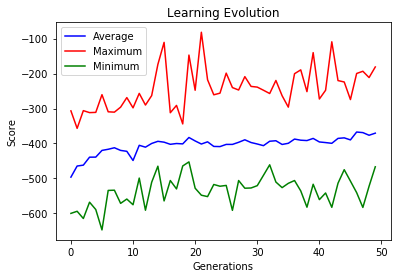

In [5]:
plotLearningEvolution(generationAverage, generationMax, generationMin)

Por último, executamos 5 gerações para o layout originalClassic:

In [ ]:
generation = createGeneration()
generationAverage, generationMax, generationMin, originalClassicStrategy = runGeneticLearning("originalClassic", generation)

layout:  originalClassic



======== STARTING GENERATION 0 ========



Pacman died! Score: -698
Pacman died! Score: -473
Pacman died! Score: -626
Average Score: -599.0
Scores:        -698.0, -473.0, -626.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -995
Pacman died! Score: -655
Pacman died! Score: -448
Average Score: -699.3333333333334
Scores:        -995.0, -655.0, -448.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -554
Pacman died! Score: -428
Pacman died! Score: -539
Average Score: -507.0
Scores:        -554.0, -428.0, -539.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -514
Pacman died! Score: -515
Pacman died! Score: -423
Average Score: -484.0
Scores:        -514.0, -515.0, -423.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -652
Pacman died! Score: -447
Pacman died! Score: -583
Average Score: -560.6666666666666
Scores:        -652.0, -447.0, -583.

Pacman died! Score: -402
Pacman died! Score: -452
Pacman died! Score: -515
Average Score: -456.3333333333333
Scores:        -402.0, -452.0, -515.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -445
Pacman died! Score: -449
Pacman died! Score: -547
Average Score: -480.3333333333333
Scores:        -445.0, -449.0, -547.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -430
Pacman died! Score: -497
Pacman died! Score: -554
Average Score: -493.6666666666667
Scores:        -430.0, -497.0, -554.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -554
Pacman died! Score: -412
Pacman died! Score: -564
Average Score: -510.0
Scores:        -554.0, -412.0, -564.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -409
Pacman died! Score: -500
Pacman died! Score: -462
Average Score: -457.0
Scores:        -409.0, -500.0, -462.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss

Pacman died! Score: -414
Pacman died! Score: -446
Pacman died! Score: -494
Average Score: -451.3333333333333
Scores:        -414.0, -446.0, -494.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -499
Pacman died! Score: -516
Pacman died! Score: -888
Average Score: -634.3333333333334
Scores:        -499.0, -516.0, -888.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -314
Pacman died! Score: -419
Pacman died! Score: -585
Average Score: -439.3333333333333
Scores:        -314.0, -419.0, -585.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -520
Pacman died! Score: -420
Pacman died! Score: -502
Average Score: -480.6666666666667
Scores:        -520.0, -420.0, -502.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -581
Pacman died! Score: -222
Pacman died! Score: -735
Average Score: -512.6666666666666
Scores:        -581.0, -222.0, -735.0
Win Rate:      0/3 (0.00)
Record:

Pacman died! Score: -412
Pacman died! Score: -514
Pacman died! Score: -427
Average Score: -451.0
Scores:        -412.0, -514.0, -427.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -397
Pacman died! Score: -536
Pacman died! Score: -494
Average Score: -475.6666666666667
Scores:        -397.0, -536.0, -494.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -430
Pacman died! Score: -449
Pacman died! Score: -440
Average Score: -439.6666666666667
Scores:        -430.0, -449.0, -440.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -448
Pacman died! Score: -596
Pacman died! Score: -459
Average Score: -501.0
Scores:        -448.0, -596.0, -459.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -456
Pacman died! Score: -422
Pacman died! Score: -597
Average Score: -491.6666666666667
Scores:        -456.0, -422.0, -597.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss

Pacman died! Score: -470
Average Score: -480.3333333333333
Scores:        -556.0, -415.0, -470.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -353
Pacman died! Score: -461
Pacman died! Score: -397
Average Score: -403.6666666666667
Scores:        -353.0, -461.0, -397.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -479
Pacman died! Score: -515
Pacman died! Score: -423
Average Score: -472.3333333333333
Scores:        -479.0, -515.0, -423.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -413
Pacman died! Score: -641
Pacman died! Score: -459
Average Score: -504.3333333333333
Scores:        -413.0, -641.0, -459.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -402
Pacman died! Score: -342
Pacman died! Score: -400
Average Score: -381.3333333333333
Scores:        -402.0, -342.0, -400.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -428


Pacman died! Score: -530
Pacman died! Score: -491
Pacman died! Score: -478
Average Score: -499.6666666666667
Scores:        -530.0, -491.0, -478.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -492
Pacman died! Score: -551
Pacman died! Score: -417
Average Score: -486.6666666666667
Scores:        -492.0, -551.0, -417.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -475
Pacman died! Score: -600
Pacman died! Score: -443
Average Score: -506.0
Scores:        -475.0, -600.0, -443.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -260
Pacman died! Score: -464
Pacman died! Score: -356
Average Score: -360.0
Scores:        -260.0, -464.0, -356.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -454
Pacman died! Score: -578
Pacman died! Score: -526
Average Score: -519.3333333333334
Scores:        -454.0, -578.0, -526.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss

Pacman died! Score: -407
Pacman died! Score: -444
Pacman died! Score: -556
Average Score: -469.0
Scores:        -407.0, -444.0, -556.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -493
Pacman died! Score: -453
Pacman died! Score: -383
Average Score: -443.0
Scores:        -493.0, -453.0, -383.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -505
Pacman died! Score: -562
Pacman died! Score: -487
Average Score: -518.0
Scores:        -505.0, -562.0, -487.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -478
Pacman died! Score: -406
Pacman died! Score: -504
Average Score: -462.6666666666667
Scores:        -478.0, -406.0, -504.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -622
Pacman died! Score: -601
Pacman died! Score: -432
Average Score: -551.6666666666666
Scores:        -622.0, -601.0, -432.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss



========

Pacman died! Score: -495
Pacman died! Score: -496
Pacman died! Score: -567
Average Score: -519.3333333333334
Scores:        -495.0, -496.0, -567.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -453
Pacman died! Score: -453
Pacman died! Score: -628
Average Score: -511.3333333333333
Scores:        -453.0, -453.0, -628.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -482
Pacman died! Score: -413
Pacman died! Score: -553
Average Score: -482.6666666666667
Scores:        -482.0, -413.0, -553.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -466
Pacman died! Score: -449
Pacman died! Score: -407
Average Score: -440.6666666666667
Scores:        -466.0, -449.0, -407.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -415
Pacman died! Score: -491
Pacman died! Score: -565
Average Score: -490.3333333333333
Scores:        -415.0, -491.0, -565.0
Win Rate:      0/3 (0.00)
Record:

Pacman died! Score: -618
Pacman died! Score: -447
Pacman died! Score: -587
Average Score: -550.6666666666666
Scores:        -618.0, -447.0, -587.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -509
Pacman died! Score: -304
Pacman died! Score: -524
Average Score: -445.6666666666667
Scores:        -509.0, -304.0, -524.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -479
Pacman died! Score: -234
Pacman died! Score: -585
Average Score: -432.6666666666667
Scores:        -479.0, -234.0, -585.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -541
Pacman died! Score: -512
Pacman died! Score: -485
Average Score: -512.6666666666666
Scores:        -541.0, -512.0, -485.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -467
Pacman died! Score: -524
Pacman died! Score: -553
Average Score: -514.6666666666666
Scores:        -467.0, -524.0, -553.0
Win Rate:      0/3 (0.00)
Record:

Pacman died! Score: -479
Pacman died! Score: -598
Pacman died! Score: -551
Average Score: -542.6666666666666
Scores:        -479.0, -598.0, -551.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -572
Pacman died! Score: -816
Pacman died! Score: -406
Average Score: -598.0
Scores:        -572.0, -816.0, -406.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -604
Pacman died! Score: -455
Pacman died! Score: -503
Average Score: -520.6666666666666
Scores:        -604.0, -455.0, -503.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -429
Pacman died! Score: -431
Pacman died! Score: -420
Average Score: -426.6666666666667
Scores:        -429.0, -431.0, -420.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -305
Pacman died! Score: -366
Pacman died! Score: -341
Average Score: -337.3333333333333
Scores:        -305.0, -366.0, -341.0
Win Rate:      0/3 (0.00)
Record:        Loss

Pacman died! Score: -491
Pacman died! Score: -516
Pacman died! Score: -432
Average Score: -479.6666666666667
Scores:        -491.0, -516.0, -432.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -465
Pacman died! Score: -454
Pacman died! Score: -166
Average Score: -361.6666666666667
Scores:        -465.0, -454.0, -166.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -641
Pacman died! Score: -457
Pacman died! Score: -472
Average Score: -523.3333333333334
Scores:        -641.0, -457.0, -472.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -616
Pacman died! Score: -521
Pacman died! Score: -792
Average Score: -643.0
Scores:        -616.0, -521.0, -792.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -323
Pacman died! Score: -497
Pacman died! Score: -356
Average Score: -392.0
Scores:        -323.0, -497.0, -356.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss

Pacman died! Score: -422
Pacman died! Score: -508
Pacman died! Score: -480
Average Score: -470.0
Scores:        -422.0, -508.0, -480.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -388
Pacman died! Score: -373
Pacman died! Score: -365
Average Score: -375.3333333333333
Scores:        -388.0, -373.0, -365.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -503
Pacman died! Score: -430
Pacman died! Score: -543
Average Score: -492.0
Scores:        -503.0, -430.0, -543.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -223
Pacman died! Score: -300
Pacman died! Score: -196
Average Score: -239.66666666666666
Scores:        -223.0, -300.0, -196.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -254
Pacman died! Score: -313
Pacman died! Score: -238
Average Score: -268.3333333333333
Scores:        -254.0, -313.0, -238.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Los

Pacman died! Score: 403
Pacman died! Score: -650
Pacman died! Score: -237
Average Score: -161.33333333333334
Scores:        403.0, -650.0, -237.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -427
Pacman died! Score: -401
Pacman died! Score: -466
Average Score: -431.3333333333333
Scores:        -427.0, -401.0, -466.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -389
Pacman died! Score: -647
Pacman died! Score: -357
Average Score: -464.3333333333333
Scores:        -389.0, -647.0, -357.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -516
Pacman died! Score: -503
Pacman died! Score: -406
Average Score: -475.0
Scores:        -516.0, -503.0, -406.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -490
Pacman died! Score: -453
Pacman died! Score: -436
Average Score: -459.6666666666667
Scores:        -490.0, -453.0, -436.0
Win Rate:      0/3 (0.00)
Record:        Loss,

Pacman died! Score: -160
Pacman died! Score: -128
Pacman died! Score: -184
Average Score: -157.33333333333334
Scores:        -160.0, -128.0, -184.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -505
Pacman died! Score: -463
Pacman died! Score: -460
Average Score: -476.0
Scores:        -505.0, -463.0, -460.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -304
Pacman died! Score: -413
Pacman died! Score: -456
Average Score: -391.0
Scores:        -304.0, -413.0, -456.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -436
Pacman died! Score: -462
Pacman died! Score: -503
Average Score: -467.0
Scores:        -436.0, -462.0, -503.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -479
Pacman died! Score: -415
Pacman died! Score: -407
Average Score: -433.6666666666667
Scores:        -479.0, -415.0, -407.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman die

Pacman died! Score: -416
Pacman died! Score: -480
Pacman died! Score: -655
Average Score: -517.0
Scores:        -416.0, -480.0, -655.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -504
Pacman died! Score: -512
Pacman died! Score: -541
Average Score: -519.0
Scores:        -504.0, -512.0, -541.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -177
Pacman died! Score: -212
Pacman died! Score: -365
Average Score: -251.33333333333334
Scores:        -177.0, -212.0, -365.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -221
Pacman died! Score: -235
Pacman died! Score: -170
Average Score: -208.66666666666666
Scores:        -221.0, -235.0, -170.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -383
Pacman died! Score: -561
Pacman died! Score: -489
Average Score: -477.6666666666667
Scores:        -383.0, -561.0, -489.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Lo

Pacman died! Score: -401
Pacman died! Score: -522
Pacman died! Score: -405
Average Score: -442.6666666666667
Scores:        -401.0, -522.0, -405.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -437
Pacman died! Score: -321
Pacman died! Score: -413
Average Score: -390.3333333333333
Scores:        -437.0, -321.0, -413.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -456
Pacman died! Score: -509
Pacman died! Score: -396
Average Score: -453.6666666666667
Scores:        -456.0, -509.0, -396.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -367
Pacman died! Score: -563
Pacman died! Score: -553
Average Score: -494.3333333333333
Scores:        -367.0, -563.0, -553.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -463
Pacman died! Score: -463
Pacman died! Score: -404
Average Score: -443.3333333333333
Scores:        -463.0, -463.0, -404.0
Win Rate:      0/3 (0.00)
Record:

Pacman died! Score: -284
Average Score: -263.3333333333333
Scores:        -365.0, -141.0, -284.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -125
Pacman died! Score: -271
Pacman died! Score: -259
Average Score: -218.33333333333334
Scores:        -125.0, -271.0, -259.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -212
Pacman died! Score: -201
Pacman died! Score: -257
Average Score: -223.33333333333334
Scores:        -212.0, -201.0, -257.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -530
Pacman died! Score: -476
Pacman died! Score: -480
Average Score: -495.3333333333333
Scores:        -530.0, -476.0, -480.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -185
Pacman died! Score: -284
Pacman died! Score: -281
Average Score: -250.0
Scores:        -185.0, -284.0, -281.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -391
Pacman die

Pacman died! Score: -464
Pacman died! Score: -418
Pacman died! Score: -506
Average Score: -462.6666666666667
Scores:        -464.0, -418.0, -506.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -513
Pacman died! Score: -501
Pacman died! Score: -517
Average Score: -510.3333333333333
Scores:        -513.0, -501.0, -517.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -407
Pacman died! Score: -396
Pacman died! Score: -484
Average Score: -429.0
Scores:        -407.0, -396.0, -484.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -383
Pacman died! Score: -257
Pacman died! Score: -221
Average Score: -287.0
Scores:        -383.0, -257.0, -221.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -504
Pacman died! Score: -413
Pacman died! Score: -436
Average Score: -451.0
Scores:        -504.0, -413.0, -436.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss



========

Pacman died! Score: -477
Pacman died! Score: -326
Pacman died! Score: -254
Average Score: -352.3333333333333
Scores:        -477.0, -326.0, -254.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -415
Pacman died! Score: -359
Pacman died! Score: -429
Average Score: -401.0
Scores:        -415.0, -359.0, -429.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -369
Pacman died! Score: -580
Pacman died! Score: -345
Average Score: -431.3333333333333
Scores:        -369.0, -580.0, -345.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -356
Pacman died! Score: -398
Pacman died! Score: -442
Average Score: -398.6666666666667
Scores:        -356.0, -398.0, -442.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -91
Pacman died! Score: -5
Pacman died! Score: -221
Average Score: -105.66666666666667
Scores:        -91.0, -5.0, -221.0
Win Rate:      0/3 (0.00)
Record:        Loss, Los

Pacman died! Score: -446
Pacman died! Score: -526
Pacman died! Score: -469
Average Score: -480.3333333333333
Scores:        -446.0, -526.0, -469.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -390
Pacman died! Score: -356
Pacman died! Score: -430
Average Score: -392.0
Scores:        -390.0, -356.0, -430.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -401
Pacman died! Score: -461
Pacman died! Score: -557
Average Score: -473.0
Scores:        -401.0, -461.0, -557.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -437
Pacman died! Score: -374
Pacman died! Score: -366
Average Score: -392.3333333333333
Scores:        -437.0, -374.0, -366.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -408
Pacman died! Score: -429
Pacman died! Score: -441
Average Score: -426.0
Scores:        -408.0, -429.0, -441.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died

Pacman died! Score: -460
Pacman died! Score: -418
Pacman died! Score: -420
Average Score: -432.6666666666667
Scores:        -460.0, -418.0, -420.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -433
Pacman died! Score: -395
Pacman died! Score: -480
Average Score: -436.0
Scores:        -433.0, -395.0, -480.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -550
Pacman died! Score: -532
Pacman died! Score: -350
Average Score: -477.3333333333333
Scores:        -550.0, -532.0, -350.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -401
Pacman died! Score: -432
Pacman died! Score: -391
Average Score: -408.0
Scores:        -401.0, -432.0, -391.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -298
Pacman died! Score: -244
Pacman died! Score: -359
Average Score: -300.3333333333333
Scores:        -298.0, -244.0, -359.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss

Pacman died! Score: -176
Pacman died! Score: -258
Pacman died! Score: -175
Average Score: -203.0
Scores:        -176.0, -258.0, -175.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -414
Pacman died! Score: -425
Pacman died! Score: -331
Average Score: -390.0
Scores:        -414.0, -425.0, -331.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -497
Pacman died! Score: -617
Pacman died! Score: -527
Average Score: -547.0
Scores:        -497.0, -617.0, -527.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -392
Pacman died! Score: -590
Pacman died! Score: -404
Average Score: -462.0
Scores:        -392.0, -590.0, -404.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -409
Pacman died! Score: -266
Pacman died! Score: -421
Average Score: -365.3333333333333
Scores:        -409.0, -266.0, -421.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -18

Pacman died! Score: -764
Pacman died! Score: -361
Average Score: -456.0
Scores:        -243.0, -764.0, -361.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -381
Pacman died! Score: -257
Pacman died! Score: -211
Average Score: -283.0
Scores:        -381.0, -257.0, -211.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -437
Pacman died! Score: -392
Pacman died! Score: -405
Average Score: -411.3333333333333
Scores:        -437.0, -392.0, -405.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -420
Pacman died! Score: -472
Pacman died! Score: -419
Average Score: -437.0
Scores:        -420.0, -472.0, -419.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -240
Pacman died! Score: -329
Pacman died! Score: -396
Average Score: -321.6666666666667
Scores:        -240.0, -329.0, -396.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -617
Pacman died

Pacman died! Score: -217
Pacman died! Score: -345
Pacman died! Score: -296
Average Score: -286.0
Scores:        -217.0, -345.0, -296.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -678
Pacman died! Score: -412
Pacman died! Score: -408
Average Score: -499.3333333333333
Scores:        -678.0, -412.0, -408.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -221
Pacman died! Score: -116
Pacman died! Score: -222
Average Score: -186.33333333333334
Scores:        -221.0, -116.0, -222.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -221
Pacman died! Score: -313
Pacman died! Score: -221
Average Score: -251.66666666666666
Scores:        -221.0, -313.0, -221.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -409
Pacman died! Score: -294
Pacman died! Score: -270
Average Score: -324.3333333333333
Scores:        -409.0, -294.0, -270.0
Win Rate:      0/3 (0.00)
Record:        Lo

Pacman died! Score: -370
Pacman died! Score: -353
Pacman died! Score: -412
Average Score: -378.3333333333333
Scores:        -370.0, -353.0, -412.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -456
Pacman died! Score: -612
Pacman died! Score: -444
Average Score: -504.0
Scores:        -456.0, -612.0, -444.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -523
Pacman died! Score: -347
Pacman died! Score: -203
Average Score: -357.6666666666667
Scores:        -523.0, -347.0, -203.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -551
Pacman died! Score: -678
Pacman died! Score: -519
Average Score: -582.6666666666666
Scores:        -551.0, -678.0, -519.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -368
Pacman died! Score: -410
Pacman died! Score: -496
Average Score: -424.6666666666667
Scores:        -368.0, -410.0, -496.0
Win Rate:      0/3 (0.00)
Record:        Loss

Pacman died! Score: -176
Pacman died! Score: -182
Pacman died! Score: -198
Average Score: -185.33333333333334
Scores:        -176.0, -182.0, -198.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -329
Pacman died! Score: -309
Pacman died! Score: -305
Average Score: -314.3333333333333
Scores:        -329.0, -309.0, -305.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -352
Pacman died! Score: -461
Pacman died! Score: -417
Average Score: -410.0
Scores:        -352.0, -461.0, -417.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -331
Pacman died! Score: -229
Pacman died! Score: -279
Average Score: -279.6666666666667
Scores:        -331.0, -229.0, -279.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -395
Pacman died! Score: -429
Pacman died! Score: -282
Average Score: -368.6666666666667
Scores:        -395.0, -429.0, -282.0
Win Rate:      0/3 (0.00)
Record:        Los

Pacman died! Score: -344
Pacman died! Score: -347
Pacman died! Score: -230
Average Score: -307.0
Scores:        -344.0, -347.0, -230.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -262
Pacman died! Score: 162
Pacman died! Score: -177
Average Score: -92.33333333333333
Scores:        -262.0, 162.0, -177.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -322
Pacman died! Score: -122
Pacman died! Score: -322
Average Score: -255.33333333333334
Scores:        -322.0, -122.0, -322.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -284
Pacman died! Score: -301
Pacman died! Score: -292
Average Score: -292.3333333333333
Scores:        -284.0, -301.0, -292.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -467
Pacman died! Score: -357
Pacman died! Score: -418
Average Score: -414.0
Scores:        -467.0, -357.0, -418.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss


Pacman died! Score: -457
Pacman died! Score: -572
Pacman died! Score: -730
Average Score: -586.3333333333334
Scores:        -457.0, -572.0, -730.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -244
Pacman died! Score: -177
Pacman died! Score: -151
Average Score: -190.66666666666666
Scores:        -244.0, -177.0, -151.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -275
Pacman died! Score: -368
Pacman died! Score: -236
Average Score: -293.0
Scores:        -275.0, -368.0, -236.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -593
Pacman died! Score: -527
Pacman died! Score: -483
Average Score: -534.3333333333334
Scores:        -593.0, -527.0, -483.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -332
Pacman died! Score: -234
Pacman died! Score: -375
Average Score: -313.6666666666667
Scores:        -332.0, -234.0, -375.0
Win Rate:      0/3 (0.00)
Record:        Los

Pacman died! Score: -449
Pacman died! Score: -355
Pacman died! Score: -470
Average Score: -424.6666666666667
Scores:        -449.0, -355.0, -470.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -275
Pacman died! Score: -234
Pacman died! Score: -298
Average Score: -269.0
Scores:        -275.0, -234.0, -298.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -447
Pacman died! Score: -318
Pacman died! Score: -462
Average Score: -409.0
Scores:        -447.0, -318.0, -462.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -106
Pacman died! Score: -365
Pacman died! Score: -257
Average Score: -242.66666666666666
Scores:        -106.0, -365.0, -257.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss



======== STARTING GENERATION 23 ========



Pacman died! Score: -176
Pacman died! Score: -31
Pacman died! Score: -326
Average Score: -177.66666666666666
Scores:        -176.0, -31.0, -326.0
Win Rate: 

Pacman died! Score: -210
Pacman died! Score: -212
Pacman died! Score: -255
Average Score: -225.66666666666666
Scores:        -210.0, -212.0, -255.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -526
Pacman died! Score: -338
Pacman died! Score: -399
Average Score: -421.0
Scores:        -526.0, -338.0, -399.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -404
Pacman died! Score: -470
Pacman died! Score: -422
Average Score: -432.0
Scores:        -404.0, -470.0, -422.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -367
Pacman died! Score: -516
Pacman died! Score: -320
Average Score: -401.0
Scores:        -367.0, -516.0, -320.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -378
Pacman died! Score: -351
Pacman died! Score: -468
Average Score: -399.0
Scores:        -378.0, -351.0, -468.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -2

Pacman died! Score: -462
Average Score: -450.6666666666667
Scores:        -450.0, -440.0, -462.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -182
Pacman died! Score: -184
Pacman died! Score: -239
Average Score: -201.66666666666666
Scores:        -182.0, -184.0, -239.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -174
Pacman died! Score: -327
Pacman died! Score: -226
Average Score: -242.33333333333334
Scores:        -174.0, -327.0, -226.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -248
Pacman died! Score: -365
Pacman died! Score: -413
Average Score: -342.0
Scores:        -248.0, -365.0, -413.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -441
Pacman died! Score: -243
Pacman died! Score: -274
Average Score: -319.3333333333333
Scores:        -441.0, -243.0, -274.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -224
Pacman die

Pacman died! Score: -187
Pacman died! Score: -410
Pacman died! Score: -213
Average Score: -270.0
Scores:        -187.0, -410.0, -213.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -263
Pacman died! Score: -252
Pacman died! Score: -307
Average Score: -274.0
Scores:        -263.0, -252.0, -307.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -424
Pacman died! Score: -481
Pacman died! Score: -571
Average Score: -492.0
Scores:        -424.0, -481.0, -571.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -369
Pacman died! Score: -103
Pacman died! Score: -456
Average Score: -309.3333333333333
Scores:        -369.0, -103.0, -456.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -481
Pacman died! Score: -416
Pacman died! Score: -450
Average Score: -449.0
Scores:        -481.0, -416.0, -450.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -18

Pacman died! Score: -372
Pacman died! Score: -240
Pacman died! Score: -367
Average Score: -326.3333333333333
Scores:        -372.0, -240.0, -367.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -549
Pacman died! Score: -611
Pacman died! Score: -543
Average Score: -567.6666666666666
Scores:        -549.0, -611.0, -543.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -811
Pacman died! Score: -465
Pacman died! Score: -346
Average Score: -540.6666666666666
Scores:        -811.0, -465.0, -346.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -337
Pacman died! Score: -233
Pacman died! Score: -309
Average Score: -293.0
Scores:        -337.0, -233.0, -309.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -50
Pacman died! Score: -168
Pacman died! Score: -231
Average Score: -149.66666666666666
Scores:        -50.0, -168.0, -231.0
Win Rate:      0/3 (0.00)
Record:        Loss,

Pacman died! Score: -177
Pacman died! Score: -221
Pacman died! Score: -764
Average Score: -387.3333333333333
Scores:        -177.0, -221.0, -764.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -187
Pacman died! Score: -288
Pacman died! Score: -229
Average Score: -234.66666666666666
Scores:        -187.0, -288.0, -229.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -504
Pacman died! Score: -402
Pacman died! Score: -504
Average Score: -470.0
Scores:        -504.0, -402.0, -504.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -241
Pacman died! Score: -347
Pacman died! Score: -309
Average Score: -299.0
Scores:        -241.0, -347.0, -309.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -427
Pacman died! Score: -414
Pacman died! Score: -240
Average Score: -360.3333333333333
Scores:        -427.0, -414.0, -240.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Los

Pacman died! Score: -332
Pacman died! Score: -339
Pacman died! Score: -189
Average Score: -286.6666666666667
Scores:        -332.0, -339.0, -189.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -518
Pacman died! Score: -470
Pacman died! Score: -433
Average Score: -473.6666666666667
Scores:        -518.0, -470.0, -433.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -388
Pacman died! Score: -305
Pacman died! Score: 290
Average Score: -134.33333333333334
Scores:        -388.0, -305.0, 290.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -174
Pacman died! Score: -257
Pacman died! Score: -212
Average Score: -214.33333333333334
Scores:        -174.0, -257.0, -212.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -585
Pacman died! Score: -451
Pacman died! Score: -324
Average Score: -453.3333333333333
Scores:        -585.0, -451.0, -324.0
Win Rate:      0/3 (0.00)
Record:

Pacman died! Score: -200
Pacman died! Score: -197
Pacman died! Score: -481
Average Score: -292.6666666666667
Scores:        -200.0, -197.0, -481.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -454
Pacman died! Score: -508
Pacman died! Score: -493
Average Score: -485.0
Scores:        -454.0, -508.0, -493.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -226
Pacman died! Score: -329
Pacman died! Score: -298
Average Score: -284.3333333333333
Scores:        -226.0, -329.0, -298.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -278
Pacman died! Score: -402
Pacman died! Score: -97
Average Score: -259.0
Scores:        -278.0, -402.0, -97.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -254
Pacman died! Score: -222
Pacman died! Score: -223
Average Score: -233.0
Scores:        -254.0, -222.0, -223.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! 

Pacman died! Score: -259
Pacman died! Score: -181
Pacman died! Score: -338
Average Score: -259.3333333333333
Scores:        -259.0, -181.0, -338.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -243
Pacman died! Score: -230
Pacman died! Score: -234
Average Score: -235.66666666666666
Scores:        -243.0, -230.0, -234.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -319
Pacman died! Score: -250
Pacman died! Score: -99
Average Score: -222.66666666666666
Scores:        -319.0, -250.0, -99.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -436
Pacman died! Score: -508
Pacman died! Score: -620
Average Score: -521.3333333333334
Scores:        -436.0, -508.0, -620.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -218
Pacman died! Score: -212
Pacman died! Score: -238
Average Score: -222.66666666666666
Scores:        -218.0, -212.0, -238.0
Win Rate:      0/3 (0.00)
Record

Pacman died! Score: -329
Pacman died! Score: -229
Pacman died! Score: -266
Average Score: -274.6666666666667
Scores:        -329.0, -229.0, -266.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -399
Pacman died! Score: -511
Pacman died! Score: -431
Average Score: -447.0
Scores:        -399.0, -511.0, -431.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -331
Pacman died! Score: -209
Pacman died! Score: -270
Average Score: -270.0
Scores:        -331.0, -209.0, -270.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -322
Pacman died! Score: 136
Pacman died! Score: -431
Average Score: -205.66666666666666
Scores:        -322.0, 136.0, -431.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -72
Pacman died! Score: -359
Pacman died! Score: -320
Average Score: -250.33333333333334
Scores:        -72.0, -359.0, -320.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
P

Pacman died! Score: -223
Pacman died! Score: -381
Pacman died! Score: -329
Average Score: -311.0
Scores:        -223.0, -381.0, -329.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -348
Pacman died! Score: -377
Pacman died! Score: -322
Average Score: -349.0
Scores:        -348.0, -377.0, -322.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -372
Pacman died! Score: -262
Pacman died! Score: -338
Average Score: -324.0
Scores:        -372.0, -262.0, -338.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -325
Pacman died! Score: -236
Pacman died! Score: -303
Average Score: -288.0
Scores:        -325.0, -236.0, -303.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -168
Pacman died! Score: -315
Pacman died! Score: -352
Average Score: -278.3333333333333
Scores:        -168.0, -315.0, -352.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -76

Pacman died! Score: -99
Pacman died! Score: 354
Pacman died! Score: -253
Average Score: 0.6666666666666666
Scores:        -99.0, 354.0, -253.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -293
Pacman died! Score: -329
Pacman died! Score: -286
Average Score: -302.6666666666667
Scores:        -293.0, -329.0, -286.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -376
Pacman died! Score: -176
Pacman died! Score: 277
Average Score: -91.66666666666667
Scores:        -376.0, -176.0, 277.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss



======== STARTING GENERATION 32 ========



Pacman died! Score: -198
Pacman died! Score: -209
Pacman died! Score: -246
Average Score: -217.66666666666666
Scores:        -198.0, -209.0, -246.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -407
Pacman died! Score: -329
Pacman died! Score: -577
Average Score: -437.6666666666667
Scores:        -407.0, -329.0

Pacman died! Score: -174
Pacman died! Score: -401
Pacman died! Score: -699
Average Score: -424.6666666666667
Scores:        -174.0, -401.0, -699.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -176
Pacman died! Score: -194
Pacman died! Score: -338
Average Score: -236.0
Scores:        -176.0, -194.0, -338.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -253
Pacman died! Score: -205
Pacman died! Score: -219
Average Score: -225.66666666666666
Scores:        -253.0, -205.0, -219.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -352
Pacman died! Score: -359
Pacman died! Score: -286
Average Score: -332.3333333333333
Scores:        -352.0, -359.0, -286.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -183
Pacman died! Score: -183
Pacman died! Score: -274
Average Score: -213.33333333333334
Scores:        -183.0, -183.0, -274.0
Win Rate:      0/3 (0.00)
Record:        Lo

Pacman died! Score: -256
Pacman died! Score: -202
Pacman died! Score: -200
Average Score: -219.33333333333334
Scores:        -256.0, -202.0, -200.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -36
Pacman died! Score: -454
Pacman died! Score: -195
Average Score: -228.33333333333334
Scores:        -36.0, -454.0, -195.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -447
Pacman died! Score: -468
Pacman died! Score: -395
Average Score: -436.6666666666667
Scores:        -447.0, -468.0, -395.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -289
Pacman died! Score: -370
Pacman died! Score: -250
Average Score: -303.0
Scores:        -289.0, -370.0, -250.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -424
Pacman died! Score: -398
Pacman died! Score: -318
Average Score: -380.0
Scores:        -424.0, -398.0, -318.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss

Pacman died! Score: -257
Average Score: -276.3333333333333
Scores:        -329.0, -243.0, -257.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: 1
Pacman died! Score: -396
Pacman died! Score: -279
Average Score: -224.66666666666666
Scores:        1.0, -396.0, -279.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -261
Pacman died! Score: -211
Pacman died! Score: -261
Average Score: -244.33333333333334
Scores:        -261.0, -211.0, -261.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -365
Pacman died! Score: -483
Pacman died! Score: -179
Average Score: -342.3333333333333
Scores:        -365.0, -483.0, -179.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -176
Pacman died! Score: -216
Pacman died! Score: -239
Average Score: -210.33333333333334
Scores:        -176.0, -216.0, -239.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -266
Pac

Pacman died! Score: -363
Pacman died! Score: -269
Pacman died! Score: -511
Average Score: -381.0
Scores:        -363.0, -269.0, -511.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -331
Pacman died! Score: -275
Pacman died! Score: -209
Average Score: -271.6666666666667
Scores:        -331.0, -275.0, -209.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -257
Pacman died! Score: -230
Pacman died! Score: -463
Average Score: -316.6666666666667
Scores:        -257.0, -230.0, -463.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -451
Pacman died! Score: -479
Pacman died! Score: -422
Average Score: -450.6666666666667
Scores:        -451.0, -479.0, -422.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -447
Pacman died! Score: -316
Pacman died! Score: -893
Average Score: -552.0
Scores:        -447.0, -316.0, -893.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss

Pacman died! Score: -403
Pacman died! Score: -361
Pacman died! Score: -373
Average Score: -379.0
Scores:        -403.0, -361.0, -373.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -320
Pacman died! Score: -178
Pacman died! Score: -251
Average Score: -249.66666666666666
Scores:        -320.0, -178.0, -251.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -275
Pacman died! Score: -212
Pacman died! Score: -201
Average Score: -229.33333333333334
Scores:        -275.0, -212.0, -201.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -195
Pacman died! Score: -215
Pacman died! Score: -169
Average Score: -193.0
Scores:        -195.0, -215.0, -169.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
Pacman died! Score: -235
Pacman died! Score: -347
Pacman died! Score: -352
Average Score: -311.3333333333333
Scores:        -235.0, -347.0, -352.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Lo

In [ ]:
plotLearningEvolution(generationAverage, generationMax, generationMin)

### Análise dos Resultados

Como podemos observar pelos gráficos acima, tivemos dificuldade em garantir que nosso algoritmo convergisse para um estratégia ótima. Isso pode ser devido a muitos fatores e tentamos algumas soluções diferentes para esse problema:

- Inicialmente, tínhamos 5 ações possíveis em cada rodada. Além das 4 direções, o pacman também poderia escolher ficar parados. Isso, porém levava a muitas estratégias nas quais o pacman ficava parado desde o início ou após um deslocamento curto. Ao retirarmos esta ação, porém, muitas estratégias terminavam com o pacman andado em loop para uma direção e para trás, o que acabou tendo um efeito similar.
- Tentamos aumentar o tamanho de uma geração para 200 e rodar 20 gerações diferentes de forma a aumentar a variabilidade genética inicial e possibilitar mais tempo para a convergência. Isso, porém, não demonstrou melhora significativa para os primeiros 2 layouts e tornou o tempo para o treino do último layout inviável.
- Testamos, também alterar a complexidade das árvores usadas para escolher as direções. Atualmente, existe uma chance de (0.9 ^ (i - 1)) * 100% de um nó ser uma folha, onde i é o nível do nó. Dessa forma, as árvores possuem uma altura mínima de 2, mas não possuem limite máximo de altura. Tentamos variar a chance de um nó ser uma folha tanto para cima quanto para baixo, e não tivemos uma mudança significativa quando testamos no primeiro layout.
- Inicialmente, o método da roleta usava a raiz quadrada de forma a diminuir a disparidade entre as estratégias na hora da escolha. Removemos isso para tentar diminuir a chance de escolha das estratégias com pior valor de fitness, de forma a tornar a convergência mais rápida.
- Alteramos, também, as porcentages de mutação e sobrevivência dos genomas, de forma a favorecer reproduções mais semelhantes a gerações anteriores, permitindo a sobrevivência das melhores estratégias.

Por fim, não conseguimos resolver o problema mesmo com as soluções propostas acima. Por isso, passamos a guardar a melhor estratégia entre todas as gerações e não apenas a útlima. Concluímos, assim, que o problema que impede a convergência provavelmente está mais relacionado com nosso modelo que com os parâmetros utilizados para o treino. Algumas alterações possíveis que poderiam solucionar isso são:

- Substituir o modelo de estratégia atual para utilizar uma matriz bidimensional de árvores de decisão ao invés de um vetor unidimensional. Dessa forma, cada linha poderia servir como um "voto" para qual direção tomar. Isso facilitaria manter as características atuais em um crossover, pois permitiria manter as linhas intactas, o que garantiria uma maior reproducibilidade das estratégias adotadas. A estratégia atual de crossover muitas vezes pode alterar drasticamente a estratégia dos pais, o que dificulta a conversão pois os descendentes de uma geração não herdam muitas das características da anterior.
- Adicionar mais valores possíveis para as árvores, especialmente informações sobre o labirinto, como coordenadas, distância e quantidade de áreas abertas, cruzamentos, cantos e etc.
- Substituir as ações atuais (4 direções) por ações mais complexas já pré-programadas, como ir para a comida mais próxima ou ir para uma posição mais distante dos fantasmas, por exemplo.
- Ajustar a função de fitness para levar em conta não apenas a pontuação. Percebemos que muitas estrátegias optavam por permanecer em apenas uma região do labirinto e, às vezes, em ir em direção a fantasmas para evitar a perda de pontos pela passagem do tempo. Enquanto essas estratégias podem ser úteis em alguns momentos, acreditamos que elas foram utilizadas demasiadamente pelos modelos que selecionávamos devido ao único critério utilizado ter sido a média da pontuação.
- Outra melhoria possível seria otimizar os algoritmos que utilizamos para obter os valores utilizados nas árvores, substituindo Dijkstra por A*, por exemplo. Notamos que o treino no layout originalClassic era muito lento não só por jogos serem mais longos, mas também porque nossos algoritmos demoravam mais tempo para processar os dados em cada rodada, o que gerava uma lentidão ainda maior no jogo. Corrigindo isso, a possibilidade de treinar mais gerações e gerações maiores seria maior. Como discutimos acima, esse aumento em si não gerou uma melhora na convergência de nosso modelo. Porém, combinado com outras medidas, poderia permitir um treino melhor.